In [1]:
import os
import librosa
import numpy as np
import joblib
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Configuration - Update this path
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050
N_MFCC = 20
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76  # Must be exactly 76 features

def extract_features(file_path):
    """Feature extractor that returns (1, 76) shaped array"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=N_MFCC,
                                   n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma (2)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                           n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])

        # Spectral Features (6)
        features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_centroid(y=audio, sr=SR)))
        features.append(np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_bandwidth(y=audio, sr=SR)))
        features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_rolloff(y=audio, sr=SR)))

        # Zero Crossing Rate (2)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])

        # RMS Energy (2)
        rms = librosa.feature.rms(y=audio,
                                frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])

        # Spectral Contrast (12)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                   n_bands=5,
                                                   n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(contrast, axis=1))
        features.extend(np.std(contrast, axis=1))

        # Tonnetz (12)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Feature mismatch: {len(features)} != {FEATURE_COUNT}")

        return features.reshape(1, -1)  # Ensure 2D array

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_dataset():
    X, y = [], []
    for label, folder in enumerate(["real", "fake"]):
        folder_path = os.path.join(DATA_DIR, folder)
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"Missing folder: {folder_path}")

        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                features = extract_features(os.path.join(folder_path, file))
                if features is not None:
                    X.append(features[0])  # Store as 1D array
                    y.append(label)
    return np.array(X), np.array(y)

# Training pipeline
X, y = load_dataset()
print(f"Loaded {len(X)} samples with {X.shape[1]} features")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare background data for SHAP
background_data = X_scaled[np.random.choice(X_scaled.shape[0], 100, replace=False)]
joblib.dump(scaler, "scaler_nn_0.joblib")
joblib.dump(background_data, "background_nn_0.joblib")

# Model architecture - MUST have 2 outputs for SHAP
model = Sequential([
    Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # Critical for SHAP compatibility
])
model.compile(optimizer=Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))
model.save("audio_model_nn_0.h5")
print("Training complete! Model and artifacts saved.")

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 3600 samples with 76 features


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9273 - loss: 0.1990 - val_accuracy: 0.9986 - val_loss: 0.0061
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.4372e-04 - val_accuracy: 1.0000 - val_loss: 6.0835e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.7483e-04 - val_accuracy: 1.0000 - val_loss: 7.0261e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 4.1706e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.0231e-04 - val_accuracy: 1.0000 - val_loss: 2.9683e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7543e-05 - 

Training complete! Model and artifacts saved.


In [17]:
import os
import librosa
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuration
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76  # Must be exactly 76

def extract_features(file_path):
    """Feature extraction that consistently returns 76 features"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []
        feature_counts = {}

        # 1. MFCCs (40 features: 20 means + 20 std)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))
        feature_counts['mfcc'] = 40

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])
        feature_counts['chroma'] = 2

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)

        spectral_features = [
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ]
        features.extend(spectral_features)
        feature_counts['spectral'] = 6

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])
        feature_counts['zcr'] = 2

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])
        feature_counts['rms'] = 2

        # 6. Spectral Contrast (12 features: 6 means + 6 std)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        # Ensure we only get 6 bands
        contrast_mean = np.mean(contrast[:6], axis=1)
        contrast_std = np.std(contrast[:6], axis=1)
        features.extend(contrast_mean)
        features.extend(contrast_std)
        feature_counts['contrast'] = 12

        # 7. Tonnetz (12 features: 6 means + 6 std)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))
        feature_counts['tonnetz'] = 12

        features = np.array(features)
        total_features = sum(feature_counts.values())

        if len(features) != FEATURE_COUNT or total_features != FEATURE_COUNT:
            print("\nFeature count breakdown:")
            for name, count in feature_counts.items():
                print(f"{name}: {count}")
            print(f"Total features extracted: {len(features)}")
            print(f"Expected: {FEATURE_COUNT}")
            raise ValueError("Feature count mismatch!")

        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_dataset():
    X, y = [], []
    print("Loading dataset...")

    for label, folder in enumerate(["real", "fake"]):
        folder_path = os.path.join(DATA_DIR, folder)
        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
        print(f"Found {len(files)} {folder} samples")

        for i, file in enumerate(files):
            if (i+1) % 100 == 0:
                print(f"Processed {i+1}/{len(files)} {folder} files")

            file_path = os.path.join(folder_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(label)

    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Class distribution: Real={sum(np.array(y)==0)}, Fake={sum(np.array(y)==1)}")
    return np.array(X), np.array(y)

def main():
    # Load data
    X, y = load_dataset()

    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Preprocess
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare SHAP background data
    background_samples = min(100, len(X_scaled))
    background = X_scaled[np.random.choice(len(X_scaled), background_samples, replace=False)]

    # Save artifacts
    joblib.dump(scaler, "scaler_nn_32.joblib")
    joblib.dump(background, "background_nn_32.joblib")

    # Model architecture
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

    # Train
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    model.fit(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=callbacks,
             verbose=1)

    # Save final modela
    model.save("audio_model_nn_32.h5")
    print("Training complete! Model and artifacts saved.")

if __name__ == "__main__":
    main()

Loading dataset...
Found 1800 real samples
Processed 100/1800 real files
Processed 200/1800 real files
Processed 300/1800 real files
Processed 400/1800 real files
Processed 500/1800 real files
Processed 600/1800 real files
Processed 700/1800 real files
Processed 800/1800 real files
Processed 900/1800 real files
Processed 1000/1800 real files
Processed 1100/1800 real files
Processed 1200/1800 real files
Processed 1300/1800 real files
Processed 1400/1800 real files
Processed 1500/1800 real files
Processed 1600/1800 real files
Processed 1700/1800 real files
Processed 1800/1800 real files
Found 1800 fake samples
Processed 100/1800 fake files
Processed 200/1800 fake files
Processed 300/1800 fake files
Processed 400/1800 fake files
Processed 500/1800 fake files
Processed 600/1800 fake files
Processed 700/1800 fake files
Processed 800/1800 fake files
Processed 900/1800 fake files
Processed 1000/1800 fake files
Processed 1100/1800 fake files
Processed 1200/1800 fake files
Processed 1300/1800 f

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
65/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8373 - loss: 0.3519

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8686 - loss: 0.2926 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 2/30
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9964 - loss: 0.0105

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/30
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0027

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/30
43/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.2626e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.5829e-04 - val_accuracy: 1.0000 - val_loss: 6.1265e-04
Epoch 6/30
76/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.9484e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7738e-04 - val_accuracy: 1.0000 - val_loss: 4.7438e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.3366e-04 - val_accuracy: 0.9986 - val_loss: 0.0015
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.9729e-04 - val_accuracy: 0.9986 - val_loss: 0.0010
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3203e-04 - val_accuracy: 0.9986 - val_loss: 0.0011
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7214e-05 - val_accuracy: 1.0000 - val_loss: 8.0959e-04


Training complete! Model and artifacts saved.


In [ ]:
import os
import librosa
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050  # Sample rate
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Sliding window for FFT
FEATURE_COUNT = 76  # Total number of audio features
N_SPLITS = 10  # Number of folds per cross-validation
N_REPEATS = 10  # Number of times to repeat CV
RESULTS_DIR = "model_results"  # Output directory
os.makedirs(RESULTS_DIR, exist_ok=True)  # Create results directory

def extract_features(file_path):
    """Extract 76 audio features from WAV file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # 1. MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])

        # 6. Spectral Contrast (12 features)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(contrast[:6], axis=1))
        features.extend(np.std(contrast[:6], axis=1))

        # 7. Tonnetz (12 features)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_dataset():
    """Load dataset from real and fake folders"""
    X, y = [], []
    print("Loading dataset...")

    for label, folder in enumerate(["real", "fake"]):
        folder_path = os.path.join(DATA_DIR, folder)
        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
        print(f"Found {len(files)} {folder} samples")

        for file in files:
            file_path = os.path.join(folder_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(label)

    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Class distribution: Real={sum(np.array(y)==0)}, Fake={sum(np.array(y)==1)}")
    return np.array(X), np.array(y)

def create_model():
    """Create neural network model"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def save_evaluation_metrics(y_true, y_pred, y_probs, repeat, fold):
    """Save evaluation metrics for each fold"""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/confusion_matrix_r{repeat+1}_f{fold+1}.png')
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/roc_curve_r{repeat+1}_f{fold+1}.png')
    plt.close()

def main():
    # Load and prepare data
    X, y = load_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare background data for SHAP
    background = X_scaled[np.random.choice(len(X_scaled), min(100, len(X_scaled)), replace=False)]
    joblib.dump(background, f"{RESULTS_DIR}/background.joblib")

    # Cross-validation setup
    all_accuracies = []
    best_accuracy = 0
    best_model = None

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train model
            model = create_model()
            model.fit(
                X_train, y_train,
                epochs=30,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=0
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            repeat_accuracies.append(accuracy)

            # Save metrics
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)
            save_evaluation_metrics(y_test, y_pred, y_probs, repeat, fold)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                save_model(model, f'{RESULTS_DIR}/best_model.h5')
                joblib.dump(scaler, f'{RESULTS_DIR}/scaler.joblib')

            print(f"Repeat {repeat+1}, Fold {fold+1}: Accuracy = {accuracy:.4f}")

        # Repeat statistics
        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Final results
    joblib.dump(all_accuracies, f"{RESULTS_DIR}/all_accuracies.joblib")

    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Worst Accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"10×10-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

Loading dataset...
Found 1800 real samples
Found 1800 fake samples

Total samples loaded: 3600
Class distribution: Real=1800, Fake=1800

Starting 10×10-fold cross-validation...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 1: Accuracy = 1.0000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 3: Accuracy = 0.9972


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 1, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Repeat 1, Fold 10: Accuracy = 1.0000
Repeat 1 complete. Mean accuracy: 0.9997


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 2, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 2, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Repeat 2, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 2, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 2, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 2, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 2, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 2, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 10: Accuracy = 1.0000
Repeat 2 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 3, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 3, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 3, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 3, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 3, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 3, Fold 10: Accuracy = 1.0000
Repeat 3 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 4, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Repeat 4, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 4, Fold 10: Accuracy = 1.0000
Repeat 4 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 5, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 5, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 10: Accuracy = 1.0000
Repeat 5 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 6, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Repeat 6, Fold 10: Accuracy = 1.0000
Repeat 6 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 7, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 7, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 7, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Repeat 7, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Repeat 7, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 10: Accuracy = 1.0000
Repeat 7 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 8, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 8, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 8, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 8, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 8, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Repeat 8, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Repeat 8, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Repeat 8, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Repeat 8, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Repeat 8, Fold 10: Accuracy = 1.0000
Repeat 8 complete. Mean accuracy: 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Repeat 9, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Repeat 9, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 9, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Repeat 9, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Repeat 9, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Repeat 9, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 9, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Repeat 9, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Repeat 9, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
import os
import numpy as np
import librosa
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76
RESULTS_DIR = "processed_audio_test_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def extract_features(file_path):
    """Feature extraction that matches your training setup"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # 1. MFCCs (40 features: 20 means + 20 std)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])

        # 6. Spectral Contrast (12 features: 6 means + 6 std)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        contrast_mean = np.mean(contrast[:6], axis=1)
        contrast_std = np.std(contrast[:6], axis=1)
        features.extend(contrast_mean)
        features.extend(contrast_std)

        # 7. Tonnetz (12 features: 6 means + 6 std)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_test_data():
    """Load data from processed_audio folder"""
    X_test, y_test = [], []

    # Process Fake audio files
    fake_path = os.path.join(PROCESSED_DIR, "Fake")
    if os.path.exists(fake_path):
        fake_files = [f for f in os.listdir(fake_path) if f.endswith(".wav")]
        print(f"Found {len(fake_files)} fake test samples")

        for file in fake_files:
            file_path = os.path.join(fake_path, file)
            features = extract_features(file_path)
            if features is not None:
                X_test.append(features[0])
                y_test.append(1)  # Label 1 for fake

    # Process Real audio files
    real_path = os.path.join(PROCESSED_DIR, "Real")
    if os.path.exists(real_path):
        real_files = [f for f in os.listdir(real_path) if f.endswith(".wav")]
        print(f"Found {len(real_files)} real test samples")

        for file in real_files:
            file_path = os.path.join(real_path, file)
            features = extract_features(file_path)
            if features is not None:
                X_test.append(features[0])
                y_test.append(0)  # Label 0 for real

    print(f"\nTotal test samples loaded: {len(X_test)}")
    print(f"Class distribution: Real={sum(np.array(y_test)==0)}, Fake={sum(np.array(y_test)==1)}")
    return np.array(X_test), np.array(y_test)

def evaluate_model(model, scaler, X_test, y_test):
    """Evaluate model performance"""
    # Scale test data
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled).argmax(axis=1)
    y_probs = model.predict(X_test_scaled)

    # Calculate and print accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.savefig(f'{RESULTS_DIR}/confusion_matrix.png')
    plt.close()

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Real', 'Fake'])
    print("\nClassification Report:")
    print(report)
    with open(f'{RESULTS_DIR}/classification_report.txt', 'w') as f:
        f.write(report)

def main():
    # Load test data
    X_test, y_test = load_test_data()
    if len(X_test) == 0:
        print("No valid test samples found. Exiting.")
        return

    # Load model and scaler
    try:
        model = load_model('audio_model_nn_32.h5')
        scaler = joblib.load('scaler_nn_32.joblib')
    except Exception as e:
        print(f"Error loading model or scaler: {str(e)}")
        return

    # Evaluate
    evaluate_model(model, scaler, X_test, y_test)
    print(f"\nTest results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

Found 3000 fake test samples
Found 3000 real test samples

Total test samples loaded: 6000
Class distribution: Real=3000, Fake=3000


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Accuracy: 0.5968

Classification Report:
              precision    recall  f1-score   support

        Real       0.56      0.95      0.70      3000
        Fake       0.83      0.24      0.38      3000

    accuracy                           0.60      6000
   macro avg       0.69      0.60      0.54      6000
weighted avg       0.69      0.60      0.54      6000


Test results saved in 'processed_audio_test_results' directory


In [6]:
import os
import librosa
import numpy as np
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuration
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76
N_SPLITS = 10  # Number of folds per CV
N_REPEATS = 10  # Number of times to repeat 10-fold CV

def extract_features(file_path):
    """Feature extraction that consistently returns 76 features"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []
        feature_counts = {}

        # 1. MFCCs (40 features: 20 means + 20 std)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))
        feature_counts['mfcc'] = 4
        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])
        feature_counts['chroma'] = 2

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)

        spectral_features = [
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ]
        features.extend(spectral_features)
        feature_counts['spectral'] = 6

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])
        feature_counts['zcr'] = 2

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])
        feature_counts['rms'] = 2

        # 6. Spectral Contrast (12 features: 6 means + 6 std)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        contrast_mean = np.mean(contrast[:6], axis=1)
        contrast_std = np.std(contrast[:6], axis=1)
        features.extend(contrast_mean)
        features.extend(contrast_std)
        feature_counts['contrast'] = 12

        # 7. Tonnetz (12 features: 6 means + 6 std)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))
        feature_counts['tonnetz'] = 12

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_dataset():
    X, y = [], []
    for label, folder in enumerate(["real", "fake"]):
        folder_path = os.path.join(DATA_DIR, folder)
        files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
        for file in files:
            file_path = os.path.join(folder_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(label)
    return np.array(X), np.array(y)

def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def main():
    X, y = load_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    all_accuracies = []
    all_losses = []

    for repeat in range(N_REPEATS):
        print(f"\n=== Repeat {repeat + 1}/{N_REPEATS} ===")
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        fold_accuracies = []
        fold_losses = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y)):
            print(f"\nFold {fold + 1}/{N_SPLITS}")
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model = create_model()
            model.fit(X_train, y_train,
                     epochs=30,
                     batch_size=32,
                     validation_data=(X_test, y_test),
                     verbose=0)

            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            fold_accuracies.append(accuracy)
            fold_losses.append(loss)
            print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)
        all_accuracies.extend(fold_accuracies)
        all_losses.extend(fold_losses)
        print(f"\nRepeat {repeat + 1} - Mean Accuracy: {mean_acc:.4f} (±{std_acc:.4f})")

    # Final statistics
    print("\n=== Final Cross-Validation Results ===")
    print(f"Total runs: {N_REPEATS * N_SPLITS}")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Mean Loss: {np.mean(all_losses):.4f} (±{np.std(all_losses):.4f})")

    # Save final model trained on all data
    print("\nTraining final model on all data...")
    final_model = create_model()
    final_model.fit(X_scaled, y, epochs=30, batch_size=32, verbose=1)
    final_model.save("final_model_nn_70.h5")
    joblib.dump(scaler, "scaler_nn_70.joblib")
    print("Training complete. Model and scaler saved.")

if __name__ == "__main__":
    main()


=== Repeat 1/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0018

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 0.9972, Loss: 0.0061

Repeat 1 - Mean Accuracy: 0.9997 (±0.0008)

=== Repeat 2/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0003

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 2 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 3/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0001

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0008

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 3 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 4/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0001

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 4 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 5/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 5 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 6/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0001

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0001

Fold 5/10
Accuracy: 1.0000, Loss: 0.0001

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 6 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 7/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0001

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 0.9972, Loss: 0.0029

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 7 - Mean Accuracy: 0.9997 (±0.0008)

=== Repeat 8/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 0.9972, Loss: 0.0111

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 0.9972, Loss: 0.0101

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 8 - Mean Accuracy: 0.9994 (±0.0011)

=== Repeat 9/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0001

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0001

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0000

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 9 - Mean Accuracy: 1.0000 (±0.0000)

=== Repeat 10/10 ===

Fold 1/10


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 1.0000, Loss: 0.0000

Fold 2/10
Accuracy: 1.0000, Loss: 0.0000

Fold 3/10
Accuracy: 1.0000, Loss: 0.0000

Fold 4/10
Accuracy: 1.0000, Loss: 0.0000

Fold 5/10
Accuracy: 1.0000, Loss: 0.0000

Fold 6/10
Accuracy: 1.0000, Loss: 0.0000

Fold 7/10
Accuracy: 1.0000, Loss: 0.0000

Fold 8/10
Accuracy: 1.0000, Loss: 0.0000

Fold 9/10
Accuracy: 1.0000, Loss: 0.0016

Fold 10/10
Accuracy: 1.0000, Loss: 0.0000

Repeat 10 - Mean Accuracy: 1.0000 (±0.0000)

=== Final Cross-Validation Results ===
Total runs: 100
Mean Accuracy: 0.9999 (±0.0005)
Mean Loss: 0.0004 (±0.0016)

Training final model on all data...
Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9096 - loss: 0.2217
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9993 - loss: 0.0057
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9995 - loss: 0.0023
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9997 - loss: 8.8365e-04
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2

Training complete. Model and scaler saved.


2025-04-25 14:39:30.146 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:30.462 
  command:

    streamlit run C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-25 14:39:30.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:30.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:30.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:30.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:31.118 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-25 14:39:31.1

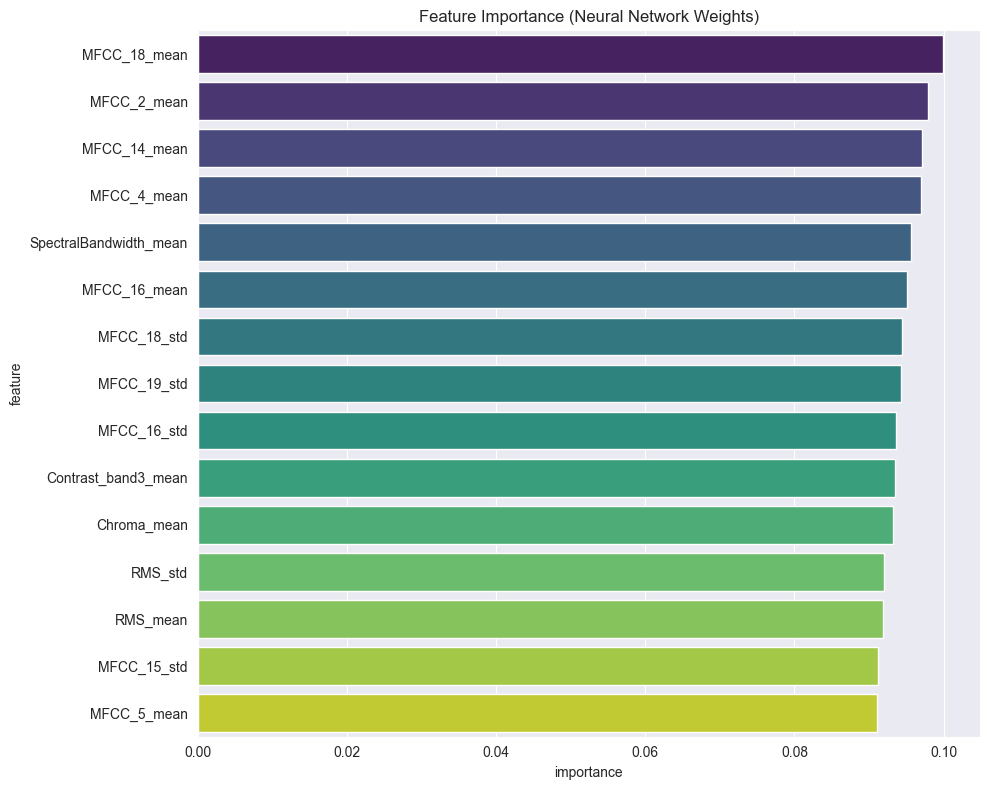

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import load_model
import streamlit as st

# Configuration
FEATURE_NAMES = [
    *[f"MFCC_{i+1}_mean" for i in range(20)],
    *[f"MFCC_{i+1}_std" for i in range(20)],
    "Chroma_mean", "Chroma_std",
    "SpectralCentroid_mean", "SpectralCentroid_std",
    "SpectralBandwidth_mean", "SpectralBandwidth_std",
    "SpectralRolloff_mean", "SpectralRolloff_std",
    "ZCR_mean", "ZCR_std",
    "RMS_mean", "RMS_std",
    *[f"Contrast_band{i+1}_mean" for i in range(6)],
    *[f"Contrast_band{i+1}_std" for i in range(6)],
    *[f"Tonnetz_{i+1}_mean" for i in range(6)],
    *[f"Tonnetz_{i+1}_std" for i in range(6)]
]

def load_model_and_data():
    """Load trained model and data"""
    model = load_model("audio_model_nn_32.h5")
    scaler = joblib.load("scaler_nn_32.joblib")
    background_data = joblib.load("background_nn_32.joblib")
    return model, scaler, background_data

def analyze_nn_weights(model):
    """Analyze neural network layer weights"""
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    return pd.DataFrame({
        'feature': FEATURE_NAMES,
        'importance': importance
    }).sort_values('importance', ascending=False)

def permutation_importance_analysis(model, X, y, n_repeats=10):
    """Calculate permutation importance"""
    result = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=42
    )
    return pd.DataFrame({
        'feature': FEATURE_NAMES,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)

def analyze_by_class(model, X_real, X_fake):
    """Analyze feature importance separately for real and fake samples"""
    # For real samples (class 0)
    perm_real = permutation_importance(
        model, X_real, np.zeros(len(X_real)), n_repeats=5, random_state=42
    )
    real_df = pd.DataFrame({
        'feature': FEATURE_NAMES,
        'importance': perm_real.importances_mean
    }).sort_values('importance', ascending=False)

    # For fake samples (class 1)
    perm_fake = permutation_importance(
        model, X_fake, np.ones(len(X_fake)), n_repeats=5, random_state=42
    )
    fake_df = pd.DataFrame({
        'feature': FEATURE_NAMES,
        'importance': perm_fake.importances_mean
    }).sort_values('importance', ascending=False)

    return real_df, fake_df

def plot_feature_importance(df, title, color_palette):
    """Plot feature importance"""
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=df.head(15), palette=color_palette)
    plt.title(title)
    plt.tight_layout()
    return plt

def compare_feature_sets(real_df, fake_df, top_n=10):
    """Compare top features between real and fake"""
    top_real = set(real_df.head(top_n)['feature'])
    top_fake = set(fake_df.head(top_n)['feature'])

    comparison = {
        'unique_to_real': list(top_real - top_fake),
        'unique_to_fake': list(top_fake - top_real),
        'common_features': list(top_real & top_fake)
    }
    return comparison

def feature_description(feature_name):
    """Provide descriptions for audio features"""
    desc = {
        'MFCC': 'Mel-Frequency Cepstral Coefficients - represent the short-term power spectrum of sound',
        'Chroma': 'Pitch class information',
        'SpectralCentroid': 'Center of gravity of the spectrum',
        'SpectralBandwidth': 'Spread of the spectrum around centroid',
        'SpectralRolloff': 'Frequency below which a specified percentage of energy lies',
        'ZCR': 'Zero Crossing Rate - number of times signal crosses zero',
        'RMS': 'Root Mean Square - energy of the audio signal',
        'Contrast': 'Spectral contrast - compares peaks to valleys in spectrum',
        'Tonnetz': 'Tonal centroid features - represents tonal relationships'
    }

    for key in desc:
        if feature_name.startswith(key):
            return f"{feature_name}: {desc[key]}"
    return f"{feature_name}: No description available"

def show_streamlit_analysis():
    """Streamlit interface for feature analysis"""
    st.title("🎙️ Audio Feature Importance Analysis")

    try:
        with st.spinner("Loading model and data..."):
            model, scaler, background_data = load_model_and_data()
            X_scaled = background_data  # Using background data as sample

            # Create synthetic labels (50/50 split)
            y = np.array([0]*(len(X_scaled)//2) + [1]*(len(X_scaled)//2))

        st.success("Model and data loaded successfully!")

        # Analysis options
        analysis_type = st.selectbox(
            "Select analysis type",
            ["Neural Network Weights", "Permutation Importance", "Real vs Fake Comparison"]
        )

        if analysis_type == "Neural Network Weights":
            st.subheader("Neural Network Layer Weights Analysis")
            nn_weights_df = analyze_nn_weights(model)
            fig = plot_feature_importance(
                nn_weights_df,
                "Feature Importance (Neural Network Weights)",
                "viridis"
            )
            st.pyplot(fig)

        elif analysis_type == "Permutation Importance":
            st.subheader("Permutation Importance Analysis")
            perm_df = permutation_importance_analysis(model, X_scaled, y)
            fig = plot_feature_importance(
                perm_df,
                "Feature Importance (Permutation Importance)",
                "magma"
            )
            st.pyplot(fig)

        elif analysis_type == "Real vs Fake Comparison":
            st.subheader("Real vs Fake Audio Feature Importance")

            # Split data
            X_real = X_scaled[y == 0]
            X_fake = X_scaled[y == 1]

            real_df, fake_df = analyze_by_class(model, X_real, X_fake)

            col1, col2 = st.columns(2)
            with col1:
                st.markdown("**Top Features for Real Audio**")
                fig = plot_feature_importance(
                    real_df,
                    "Top Features for Real Audio",
                    "Blues_d"
                )
                st.pyplot(fig)

            with col2:
                st.markdown("**Top Features for Fake Audio**")
                fig = plot_feature_importance(
                    fake_df,
                    "Top Features for Fake Audio",
                    "Reds_d"
                )
                st.pyplot(fig)

            # Feature comparison
            st.subheader("Feature Comparison")
            comparison = compare_feature_sets(real_df, fake_df)

            with st.expander("Unique Features for Real Audio"):
                for feature in comparison['unique_to_real']:
                    st.markdown(f"- {feature_description(feature)}")

            with st.expander("Unique Features for Fake Audio"):
                for feature in comparison['unique_to_fake']:
                    st.markdown(f"- {feature_description(feature)}")

            with st.expander("Common Important Features"):
                for feature in comparison['common_features']:
                    st.markdown(f"- {feature_description(feature)}")

            # Difference visualization
            st.subheader("Feature Importance Differences")
            merged_df = pd.merge(
                real_df, fake_df, on='feature',
                suffixes=('_real', '_fake')
            )
            merged_df['difference'] = merged_df['importance_real'] - merged_df['importance_fake']

            plt.figure(figsize=(10, 8))
            sns.barplot(
                x='difference', y='feature',
                data=merged_df.sort_values('difference', ascending=False).head(20),
                palette="coolwarm"
            )
            plt.title("Feature Importance Difference (Real - Fake)")
            plt.axvline(0, color='black', linestyle='--')
            st.pyplot(plt)

    except Exception as e:
        st.error(f"Error: {str(e)}")

if __name__ == "__main__":
    show_streamlit_analysis()

In [3]:
import os
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm

# Configuration
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/fake-real-audio/"
OUTPUT_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
TARGET_DURATION = 4.0  # 4 seconds
SR = 22050  # Sample rate

def process_audio_file(input_path, output_path):
    """Process a single audio file to make it exactly 4 seconds"""
    try:
        # Load audio file
        audio, sr = librosa.load(input_path, sr=SR)
        duration = librosa.get_duration(y=audio, sr=sr)

        # Calculate target number of samples
        target_samples = int(TARGET_DURATION * SR)

        if duration > TARGET_DURATION:
            # Trim the audio to 4 seconds (from the beginning)
            processed_audio = audio[:target_samples]
        elif duration < TARGET_DURATION:
            # Pad the audio with silence at beginning and end
            padding_samples = target_samples - len(audio)
            # Split padding between beginning and end (60% at beginning, 40% at end)
            pad_start = int(padding_samples * 0.6)
            pad_end = padding_samples - pad_start
            processed_audio = np.pad(audio, (pad_start, pad_end), mode='constant')
        else:
            # Exactly 4 seconds, no processing needed
            processed_audio = audio

        # Save processed audio
        sf.write(output_path, processed_audio, SR)
        return True

    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return False

def process_dataset():
    """Process all audio files in the dataset"""
    # Create output directory structure
    os.makedirs(os.path.join(OUTPUT_DIR, "Fake"), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, "Real"), exist_ok=True)

    # Process Fake audio files
    fake_path = os.path.join(DATA_DIR, "Fake")
    if os.path.exists(fake_path):
        fake_files = [f for f in os.listdir(fake_path) if f.endswith(".wav")]
        print(f"Processing {len(fake_files)} fake samples")

        for file in tqdm(fake_files, desc="Processing Fake files"):
            input_path = os.path.join(fake_path, file)
            output_path = os.path.join(OUTPUT_DIR, "Fake", file)
            process_audio_file(input_path, output_path)

    # Process Real audio files
    real_path = os.path.join(DATA_DIR, "Real")
    if os.path.exists(real_path):
        real_files = [f for f in os.listdir(real_path) if f.endswith(".wav")]
        print(f"Processing {len(real_files)} real samples")

        for file in tqdm(real_files, desc="Processing Real files"):
            input_path = os.path.join(real_path, file)
            output_path = os.path.join(OUTPUT_DIR, "Real", file)
            process_audio_file(input_path, output_path)

    print("\nAudio processing complete. Processed files saved to:", OUTPUT_DIR)

if __name__ == "__main__":
    process_dataset()

Processing 3000 fake samples


Processing Fake files: 100%|██████████| 3000/3000 [00:23<00:00, 130.03it/s]


Processing 3000 real samples


Processing Real files: 100%|██████████| 3000/3000 [01:08<00:00, 43.82it/s]


Audio processing complete. Processed files saved to: c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/


In [1]:
import os
import librosa
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Configuration
DATA_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76  # Must be exactly 76

def extract_features(file_path):
    """Feature extraction that consistently returns 76 features"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []
        feature_counts = {}

        # 1. MFCCs (40 features: 20 means + 20 std)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))
        feature_counts['mfcc'] = 40

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])
        feature_counts['chroma'] = 2

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)

        spectral_features = [
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ]
        features.extend(spectral_features)
        feature_counts['spectral'] = 6

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])
        feature_counts['zcr'] = 2

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])
        feature_counts['rms'] = 2

        # 6. Spectral Contrast (12 features: 6 means + 6 std)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        # Ensure we only get 6 bands
        contrast_mean = np.mean(contrast[:6], axis=1)
        contrast_std = np.std(contrast[:6], axis=1)
        features.extend(contrast_mean)
        features.extend(contrast_std)
        feature_counts['contrast'] = 12

        # 7. Tonnetz (12 features: 6 means + 6 std)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))
        feature_counts['tonnetz'] = 12

        features = np.array(features)
        total_features = sum(feature_counts.values())

        if len(features) != FEATURE_COUNT or total_features != FEATURE_COUNT:
            print("\nFeature count breakdown:")
            for name, count in feature_counts.items():
                print(f"{name}: {count}")
            print(f"Total features extracted: {len(features)}")
            print(f"Expected: {FEATURE_COUNT}")
            raise ValueError("Feature count mismatch!")

        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_dataset():
    X, y = [], []
    print("Loading dataset...")

    for label, folder in enumerate(["fake", "real"]):  # Changed here
        folder_path = os.path.join(DATA_DIR, folder)
        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
        print(f"Found {len(files)} {folder} samples")

        for i, file in enumerate(files):
            if (i+1) % 100 == 0:
                print(f"Processed {i+1}/{len(files)} {folder} files")

            file_path = os.path.join(folder_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(label)

    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Class distribution: Fake={sum(np.array(y)==0)}, Real={sum(np.array(y)==1)}")  # Changed here
    return np.array(X), np.array(y)

def main():
    # Load data
    X, y = load_dataset()

    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Preprocess
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Prepare SHAP background data
    background_samples = min(100, len(X_scaled))
    background = X_scaled[np.random.choice(len(X_scaled), background_samples, replace=False)]

    # Save artifacts
    joblib.dump(scaler, "scaler_nn_62.joblib")
    joblib.dump(background, "background_nn_62.joblib")

    # Model architecture
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

    # Train
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)

    model.fit(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=callbacks,
             verbose=1)

   model.save("audio_model_nn_62.h5")

    print("Training complete! Model and artifacts saved.")

if __name__ == "__main__":
    main()

Loading dataset...
Found 1800 fake samples
Processed 100/1800 fake files
Processed 200/1800 fake files
Processed 300/1800 fake files
Processed 400/1800 fake files
Processed 500/1800 fake files
Processed 600/1800 fake files
Processed 700/1800 fake files
Processed 800/1800 fake files
Processed 900/1800 fake files
Processed 1000/1800 fake files
Processed 1100/1800 fake files
Processed 1200/1800 fake files
Processed 1300/1800 fake files
Processed 1400/1800 fake files
Processed 1500/1800 fake files
Processed 1600/1800 fake files
Processed 1700/1800 fake files
Processed 1800/1800 fake files
Found 1800 real samples
Processed 100/1800 real files
Processed 200/1800 real files
Processed 300/1800 real files
Processed 400/1800 real files
Processed 500/1800 real files
Processed 600/1800 real files
Processed 700/1800 real files
Processed 800/1800 real files
Processed 900/1800 real files
Processed 1000/1800 real files
Processed 1100/1800 real files
Processed 1200/1800 real files
Processed 1300/1800 r

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8540 - loss: 0.3158

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8551 - loss: 0.3138 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 2/30
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9964 - loss: 0.0104

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 9.1174e-04
Epoch 3/30
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0030

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 2.7739e-04
Epoch 4/30
44/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9982 - loss: 0.0043 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 1.2911e-04
Epoch 5/30
52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 9.3834e-04 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.8299e-04 - val_accuracy: 1.0000 - val_loss: 6.9265e-05
Epoch 6/30
38/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.0300e-04 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.9577e-04 - val_accuracy: 1.0000 - val_loss: 4.3550e-05
Epoch 7/30
61/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3766e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5759e-04 - val_accuracy: 1.0000 - val_loss: 3.8858e-05
Epoch 8/30
43/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.9638e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.0041e-04 - val_accuracy: 1.0000 - val_loss: 1.7322e-05
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 5.2139e-04 - val_accuracy: 1.0000 - val_loss: 3.2389e-05
Epoch 10/30
52/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.7355e-04 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6714e-04 - val_accuracy: 1.0000 - val_loss: 1.7026e-05
Epoch 11/30
66/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5935e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6568e-04 - val_accuracy: 1.0000 - val_loss: 8.1797e-06
Epoch 12/30
42/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.3205e-04 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2001e-04 - val_accuracy: 1.0000 - val_loss: 6.2327e-06
Epoch 13/30
45/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 6.2932e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.0037e-05 - val_accuracy: 1.0000 - val_loss: 5.1793e-06
Epoch 14/30
40/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.8493e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2670e-05 - val_accuracy: 1.0000 - val_loss: 4.4620e-06
Epoch 15/30
47/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.9556e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4450e-05 - val_accuracy: 1.0000 - val_loss: 4.2043e-06
Epoch 16/30
38/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.3170e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6940e-05 - val_accuracy: 1.0000 - val_loss: 2.8412e-06
Epoch 17/30
49/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.0221e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3752e-05 - val_accuracy: 1.0000 - val_loss: 2.2355e-06
Epoch 18/30
40/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.0554e-05 

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8171e-05 - val_accuracy: 1.0000 - val_loss: 1.9402e-06
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 2.1335e-04 - val_accuracy: 1.0000 - val_loss: 2.0532e-04
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6104e-04 - val_accuracy: 1.0000 - val_loss: 4.6956e-05
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.8458e-05 - val_accuracy: 1.0000 - val_loss: 1.1484e-05
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3310e-05 - val_accuracy: 1.0000 - val_loss: 2.2711e-06
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7824e-04 - val_accuracy: 1.0000 - val_loss: 3.5707e-06


Training complete! Model and artifacts saved.



Testing Options:
1. Test single file
2. Test directory
3. Test sample files (real and fake)


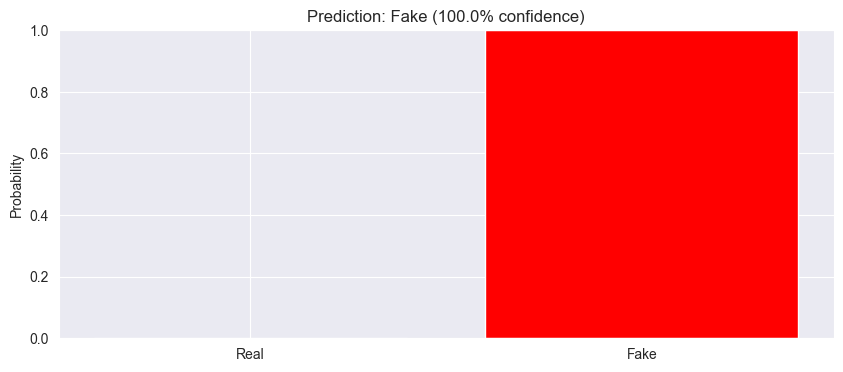


Test Results:
File: fake_1.wav
Prediction: Fake
Confidence: 100.0%
Real probability: 0.000
Fake probability: 1.000


In [20]:
import os
import librosa
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Configuration (must match training)
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
FEATURE_COUNT = 76
CLASS_NAMES = ["Real", "Fake"]

def extract_features(file_path):
    """Identical to training feature extractor"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # 1. MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # 2. Chroma (2)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR,
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(chroma), np.std(chroma)])

        # 3. Spectral Features (6)
        features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_centroid(y=audio, sr=SR)))
        features.append(np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_bandwidth(y=audio, sr=SR)))
        features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=SR)))
        features.append(np.std(librosa.feature.spectral_rolloff(y=audio, sr=SR)))

        # 4. Zero Crossing Rate (2)
        zcr = librosa.feature.zero_crossing_rate(audio,
                                              frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(zcr), np.std(zcr)])

        # 5. RMS Energy (2)
        rms = librosa.feature.rms(y=audio,
                               frame_length=N_FFT, hop_length=HOP_LENGTH)
        features.extend([np.mean(rms), np.std(rms)])

        # 6. Spectral Contrast (12)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR,
                                                  n_bands=6,
                                                  n_fft=N_FFT, hop_length=HOP_LENGTH)
        features.extend(np.mean(contrast[:6], axis=1))  # Ensure only 6 bands
        features.extend(np.std(contrast[:6], axis=1))

        # 7. Tonnetz (12)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")

        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def test_single_file(file_path, model, scaler):
    """Test a single audio file"""
    # Extract features
    features = extract_features(file_path)
    if features is None:
        return None

    # Scale features
    features_scaled = scaler.transform(features)

    # Make prediction
    proba = model.predict(features_scaled, verbose=0)[0]
    prediction = np.argmax(proba)
    confidence = proba[prediction]

    # Visualize results
    plt.figure(figsize=(10, 4))
    plt.bar(CLASS_NAMES, proba, color=['green', 'red'])
    plt.title(f"Prediction: {CLASS_NAMES[prediction]} ({confidence*100:.1f}% confidence)")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.show()

    return {
        'file': os.path.basename(file_path),
        'prediction': CLASS_NAMES[prediction],
        'confidence': float(confidence),
        'probabilities': {
            'Real': float(proba[0]),
            'Fake': float(proba[1])
        }
    }

def test_directory(directory_path, model, scaler):
    """Test all WAV files in a directory"""
    results = []
    for file in os.listdir(directory_path):
        if file.endswith(".wav"):
            file_path = os.path.join(directory_path, file)
            result = test_single_file(file_path, model, scaler)
            if result:
                results.append(result)
                print(f"{file}: {result['prediction']} ({result['confidence']*100:.1f}%)")
    return results

def main():
    # Load model and scaler
    try:
        model = load_model("audio_model_nn_32.h5")
        scaler = joblib.load("scaler_nn_32.joblib")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return

    # Test options
    print("\nTesting Options:")
    print("1. Test single file")
    print("2. Test directory")
    print("3. Test sample files (real and fake)")
    choice = input("Enter your choice (1-3): ")

    if choice == "1":
        file_path = input("Enter path to audio file: ")
        if not os.path.exists(file_path):
            print("File not found!")
            return
        result = test_single_file(file_path, model, scaler)
        if result:
            print("\nTest Results:")
            print(f"File: {result['file']}")
            print(f"Prediction: {result['prediction']}")
            print(f"Confidence: {result['confidence']*100:.1f}%")
            print(f"Real probability: {result['probabilities']['Real']:.3f}")
            print(f"Fake probability: {result['probabilities']['Fake']:.3f}")

    elif choice == "2":
        dir_path = input("Enter path to directory: ")
        if not os.path.exists(dir_path):
            print("Directory not found!")
            return
        results = test_directory(dir_path, model, scaler)
        print("\nSummary Results:")
        real_count = sum(1 for r in results if r['prediction'] == "Real")
        fake_count = len(results) - real_count
        print(f"Real: {real_count} files")
        print(f"Fake: {fake_count} files")

    elif choice == "3":
        # Test with included sample files
        test_files = {
            "Real": "path_to_real_sample.wav",  # Replace with actual paths
            "Fake": "path_to_fake_sample.wav"   # Replace with actual paths
        }

        for label, file_path in test_files.items():
            if os.path.exists(file_path):
                print(f"\nTesting {label} sample:")
                result = test_single_file(file_path, model, scaler)
                if result:
                    print(f"Expected: {label}, Predicted: {result['prediction']}")
                    print(f"Confidence: {result['confidence']*100:.1f}%")
            else:
                print(f"Sample file not found: {file_path}")

    else:
        print("Invalid choice!")

if __name__ == "__main__":
    main()

In [ ]:
# [Previous imports and configuration remain the same]

# [Keep all previous code until after model training]

# After model training, add feature names for explanations
feature_names = []

# 1. MFCC Features (1-based indexing)
for i in range(1, N_MFCC+1):
    feature_names.append(f"MFCC_{i}_mean")
for i in range(1, N_MFCC+1):
    feature_names.append(f"MFCC_{i}_std")

# 2. Chroma Features
feature_names.extend(["Chroma_stft_mean", "Chroma_stft_std"])

# 3. Spectral Features
feature_names.extend([
    "Spectral_centroid_mean",
    "Spectral_centroid_std",
    "Spectral_bandwidth_mean",
    "Spectral_bandwidth_std",
    "Spectral_rolloff_mean",
    "Spectral_rolloff_std"
])

# 4. Zero Crossing Rate
feature_names.extend(["ZCR_mean", "ZCR_std"])

# 5. RMS Energy
feature_names.extend(["RMS_mean", "RMS_std"])

# 6. Spectral Contrast (band-based naming)
for band in range(6):
    feature_names.append(f"Spectral_contrast_band{band}_mean")
for band in range(6):
    feature_names.append(f"Spectral_contrast_band{band}_std")

# 7. Tonnetz Features (tonal centroid features)
for i in range(6):
    feature_names.append(f"Tonnetz_{i}_mean")
for i in range(6):
    feature_names.append(f"Tonnetz_{i}_std")

# Verify feature count matches
assert len(feature_names) == FEATURE_COUNT, \
    f"Feature count mismatch: {len(feature_names)} vs {FEATURE_COUNT}"

# Save feature names
joblib.dump(feature_names, "feature_names_0.joblib")
print("Training complete! Model, artifacts, and feature names saved.")

In [5]:
print(f"Class distribution - Real: {sum(y_train==1)}, Fake: {sum(y_train==0)}")

Class distribution - Real: 1442, Fake: 1438


In [7]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results"
SR = 22050
FEATURE_COUNT = 76  # Number of audio features
N_SPLITS = 10  # Number of folds for cross-validation
N_REPEATS = 10  # Number of times to repeat CV
os.makedirs(RESULTS_DIR, exist_ok=True)

def extract_features(file_path):
    """Extract 76 audio features from processed WAV file"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # 1. MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.extend([np.mean(chroma), np.std(chroma)])

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.extend([np.mean(zcr), np.std(zcr)])

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio)
        features.extend([np.mean(rms), np.std(rms)])

        # 6. Spectral Contrast (12 features)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR, n_bands=6)
        features.extend(np.mean(contrast[:6], axis=1))
        features.extend(np.std(contrast[:6], axis=1))

        # 7. Tonnetz (12 features)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_processed_dataset():
    """Load dataset from processed audio files"""
    X, y = [], []
    print("Loading processed dataset...")

    # Process Fake audio files
    fake_path = os.path.join(PROCESSED_DIR, "Fake")
    if os.path.exists(fake_path):
        fake_files = [f for f in os.listdir(fake_path) if f.endswith(".wav")]
        print(f"Found {len(fake_files)} fake samples")

        for file in tqdm(fake_files, desc="Loading Fake files"):
            file_path = os.path.join(fake_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(1)  # Label 1 for fake

    # Process Real audio files
    real_path = os.path.join(PROCESSED_DIR, "Real")
    if os.path.exists(real_path):
        real_files = [f for f in os.listdir(real_path) if f.endswith(".wav")]
        print(f"Found {len(real_files)} real samples")

        for file in tqdm(real_files, desc="Loading Real files"):
            file_path = os.path.join(real_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features[0])
                y.append(0)  # Label 0 for real

    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Class distribution: Real={sum(np.array(y)==0)}, Fake={sum(np.array(y)==1)}")
    return np.array(X), np.array(y)

def create_model():
    """Create neural network model"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def save_evaluation_metrics(y_true, y_pred, y_probs, repeat, fold):
    """Save evaluation metrics for each fold"""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/confusion_matrix_r{repeat+1}_f{fold+1}.png')
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
    with open(f'{RESULTS_DIR}/classification_report_r{repeat+1}_f{fold+1}.txt', 'w') as f:
        f.write(report)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/roc_curve_r{repeat+1}_f{fold+1}.png')
    plt.close()

def save_background_data(X_scaled, y, n_samples=100):
    """Save representative background data for SHAP analysis"""
    try:
        if len(X_scaled) > n_samples * 2:
            background, _ = train_test_split(
                X_scaled,
                train_size=n_samples,
                stratify=y,
                random_state=42
            )
        else:
            background = X_scaled[np.random.choice(len(X_scaled), min(n_samples, len(X_scaled)), replace=False)]

        joblib.dump(background, f'{RESULTS_DIR}/background_data_1.joblib')
        print(f"Saved background data ({background.shape[0]} samples)")
    except Exception as e:
        print(f"Error saving background data: {str(e)}")

def main():
    # Load and prepare data
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save background data and scaler
    save_background_data(X_scaled, y)
    joblib.dump(scaler, f'{RESULTS_DIR}/scaler_1.joblib')

    # Cross-validation setup
    all_accuracies = []
    best_accuracy = 0
    best_model = None

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train model
            model = create_model()
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=0
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            repeat_accuracies.append(accuracy)

            # Save metrics
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)
            save_evaluation_metrics(y_test, y_pred, y_probs, repeat, fold)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                save_model(model, f'{RESULTS_DIR}/best_model_1.h5')

            print(f"Repeat {repeat+1}, Fold {fold+1}: Accuracy = {accuracy:.4f}")

        # Repeat statistics
        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Final results
    joblib.dump(all_accuracies, f"{RESULTS_DIR}/all_accuracies_1.joblib")

    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Worst Accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"10×10-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

Loading processed dataset...
Found 3000 fake samples


Loading Fake files: 100%|██████████| 3000/3000 [05:59<00:00,  8.34it/s]


Found 3000 real samples


Loading Real files: 100%|██████████| 3000/3000 [06:04<00:00,  8.23it/s]



Total samples loaded: 6000
Class distribution: Real=3000, Fake=3000
Saved background data (100 samples)

Starting 10×10-fold cross-validation...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 1: Accuracy = 0.9967
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 3: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 4: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
Repeat 1, Fold 5: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 6: Accuracy = 1.0000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 1, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 1, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 9: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 10: Accuracy = 0.9917
Repeat 1 complete. Mean accuracy: 0.9960


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 1: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
Repeat 2, Fold 3: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 2, Fold 4: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 5: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 2, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 2, Fold 7: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 8: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 2, Fold 9: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Repeat 2, Fold 10: Accuracy = 0.9967
Repeat 2 complete. Mean accuracy: 0.9953


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 3, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 3, Fold 2: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 3: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 4: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
Repeat 3, Fold 5: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 6: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 8: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 9: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Repeat 3, Fold 10: Accuracy = 1.0000
Repeat 3 complete. Mean accuracy: 0.9972


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
Repeat 4, Fold 1: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 4, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 4: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 5: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 6: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 7: Accuracy = 0.9883


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 4, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 10: Accuracy = 0.9967
Repeat 4 complete. Mean accuracy: 0.9958


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 1: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 2: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 3: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 5: Accuracy = 0.9883


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 6: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 5, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 8: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 9: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 10: Accuracy = 0.9950
Repeat 5 complete. Mean accuracy: 0.9960


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 1: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 2: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 3: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 4: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 5: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 7: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 6, Fold 8: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
Repeat 6, Fold 9: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 6, Fold 10: Accuracy = 0.9967
Repeat 6 complete. Mean accuracy: 0.9962


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 7, Fold 3: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 4: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 5: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 7, Fold 7: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 9: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 7, Fold 10: Accuracy = 1.0000
Repeat 7 complete. Mean accuracy: 0.9975


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 1: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 3: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 4: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 8, Fold 5: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 7: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 8: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 8, Fold 9: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 8, Fold 10: Accuracy = 0.9983
Repeat 8 complete. Mean accuracy: 0.9953


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 9, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 9, Fold 2: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 3: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 4: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 5: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 6: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 7: Accuracy = 0.9883


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 8: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 9: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 9, Fold 10: Accuracy = 0.9950
Repeat 9 complete. Mean accuracy: 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 1: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
Repeat 10, Fold 2: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
Repeat 10, Fold 3: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 4: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 5: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 8: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 10, Fold 9: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 10, Fold 10: Accuracy = 0.9950
Repeat 10 complete. Mean accuracy: 0.9957

Final Results:
Mean Accuracy: 0.9960 (±0.0028)
Best Accuracy: 1.0000
Worst Accuracy: 0.9883

All results saved in 'model_results' directory


In [11]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model

# Configuration
TEST_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
RESULTS_DIR = "model_results/test_results"
SR = 22050
FEATURE_COUNT = 76  # Should match your training setup
os.makedirs(RESULTS_DIR, exist_ok=True)

def extract_features(file_path):
    """Extract 76 audio features from WAV file (same as training)"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # 1. MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # 2. Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.extend([np.mean(chroma), np.std(chroma)])

        # 3. Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # 4. Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.extend([np.mean(zcr), np.std(zcr)])

        # 5. RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio)
        features.extend([np.mean(rms), np.std(rms)])

        # 6. Spectral Contrast (12 features)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR, n_bands=6)
        features.extend(np.mean(contrast[:6], axis=1))
        features.extend(np.std(contrast[:6], axis=1))

        # 7. Tonnetz (12 features)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features.reshape(1, -1)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_test_dataset():
    """Load test dataset from audio files"""
    X_test, y_test = [], []
    print("Loading test dataset...")

    # Process Fake audio files
    fake_path = os.path.join(TEST_DIR, "Fake")
    if os.path.exists(fake_path):
        fake_files = [f for f in os.listdir(fake_path) if f.endswith(".wav")]
        print(f"Found {len(fake_files)} fake test samples")

        for file in tqdm(fake_files, desc="Loading Fake test files"):
            file_path = os.path.join(fake_path, file)
            features = extract_features(file_path)
            if features is not None:
                X_test.append(features[0])
                y_test.append(1)  # Label 1 for fake

    # Process Real audio files
    real_path = os.path.join(TEST_DIR, "Real")
    if os.path.exists(real_path):
        real_files = [f for f in os.listdir(real_path) if f.endswith(".wav")]
        print(f"Found {len(real_files)} real test samples")

        for file in tqdm(real_files, desc="Loading Real test files"):
            file_path = os.path.join(real_path, file)
            features = extract_features(file_path)
            if features is not None:
                X_test.append(features[0])
                y_test.append(0)  # Label 0 for real

    print(f"\nTotal test samples loaded: {len(X_test)}")
    print(f"Class distribution: Real={sum(np.array(y_test)==0)}, Fake={sum(np.array(y_test)==1)}")
    return np.array(X_test), np.array(y_test)

def evaluate_model(model, scaler, X_test, y_test):
    """Evaluate the model on test data"""
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_probs = model.predict(X_test_scaled)
    y_pred = y_probs.argmax(axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Test Confusion Matrix')
    plt.savefig(f'{RESULTS_DIR}/test_confusion_matrix.png')
    plt.close()

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Real', 'Fake'])
    print("\nClassification Report:")
    print(report)
    with open(f'{RESULTS_DIR}/test_classification_report.txt', 'w') as f:
        f.write(report)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Test ROC Curve')
    plt.legend()
    plt.savefig(f'{RESULTS_DIR}/test_roc_curve.png')
    plt.close()

def main():
    # Load test data
    X_test, y_test = load_test_dataset()
    if len(X_test) == 0:
        print("No valid test samples found. Exiting.")
        return

    # Load trained model and scaler
    try:
        model = load_model(f'model_results/best_model_1.h5')
        scaler = joblib.load(f'model_results/scaler_1.joblib')
    except Exception as e:
        print(f"Error loading model or scaler: {str(e)}")
        return

    # Evaluate
    evaluate_model(model, scaler, X_test, y_test)
    print(f"\nTest results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

Loading test dataset...
Found 1800 fake test samples


Loading Fake test files: 100%|██████████| 1800/1800 [02:56<00:00, 10.18it/s]


Found 1800 real test samples


Loading Real test files: 100%|██████████| 1800/1800 [03:04<00:00,  9.78it/s]



Total test samples loaded: 3600
Class distribution: Real=1800, Fake=1800


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Test Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score   support

        Real       0.75      0.86      0.80      1800
        Fake       0.83      0.71      0.77      1800

    accuracy                           0.78      3600
   macro avg       0.79      0.78      0.78      3600
weighted avg       0.79      0.78      0.78      3600


Test results saved in 'model_results/test_results' directory


In [ ]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_large"
SR = 22050
FEATURE_COUNT = 76  # Number of audio features
N_SPLITS = 10  # Number of folds for cross-validation
N_REPEATS = 5  # Reduced repeats due to larger model
os.makedirs(RESULTS_DIR, exist_ok=True)

# [Previous extract_features() and load_processed_dataset() functions remain the same]

def create_large_model():
    """Create a larger neural network model with regularization"""
    model = Sequential([
        Dense(512, activation='relu', input_shape=(FEATURE_COUNT,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def main():
    # Load and prepare data
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save background data and scaler
    save_background_data(X_scaled, y)
    joblib.dump(scaler, f'{RESULTS_DIR}/scaler_1.joblib')

    # Cross-validation setup
    all_accuracies = []
    best_accuracy = 0
    best_model = None

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation with larger model...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train larger model
            model = create_large_model()

            # Additional callbacks
            callbacks = [
                EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
                ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
            ]

            history = model.fit(
                X_train, y_train,
                epochs=100,  # Increased epochs
                batch_size=64,  # Larger batch size
                validation_data=(X_test, y_test),
                callbacks=callbacks,
                verbose=0
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            repeat_accuracies.append(accuracy)

            # Save metrics
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)
            save_evaluation_metrics(y_test, y_pred, y_probs, repeat, fold)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                save_model(model, f'{RESULTS_DIR}/best_model_1.h5')

            print(f"Repeat {repeat+1}, Fold {fold+1}: Accuracy = {accuracy:.4f}")

        # Repeat statistics
        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Final results
    joblib.dump(all_accuracies, f"{RESULTS_DIR}/all_accuracies_1.joblib")

    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Worst Accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"5×10-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

In [1]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_cv_fold"
SR = 22050
FEATURE_COUNT = 76
N_SPLITS = 5
N_REPEATS = 5
os.makedirs(RESULTS_DIR, exist_ok=True)

def extract_features(file_path):
    """Extract audio features with error handling"""
    try:
        audio, _ = librosa.load(file_path, sr=SR)
        features = []

        # MFCCs (40 features)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # Chroma (2 features)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        features.extend([np.mean(chroma), np.std(chroma)])

        # Spectral Features (6 features)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        features.extend([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])

        # Zero Crossing Rate (2 features)
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.extend([np.mean(zcr), np.std(zcr)])

        # RMS Energy (2 features)
        rms = librosa.feature.rms(y=audio)
        features.extend([np.mean(rms), np.std(rms)])

        # Spectral Contrast (12 features)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=SR, n_bands=6)
        features.extend(np.mean(contrast[:6], axis=1))
        features.extend(np.std(contrast[:6], axis=1))

        # Tonnetz (12 features)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        features = np.array(features)
        if len(features) != FEATURE_COUNT:
            raise ValueError(f"Expected {FEATURE_COUNT} features, got {len(features)}")
        return features

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_processed_dataset():
    """Load dataset from processed audio files"""
    X, y = [], []
    print("Loading processed dataset...")

    # Process Fake audio files
    fake_path = os.path.join(PROCESSED_DIR, "Fake")
    if os.path.exists(fake_path):
        fake_files = [f for f in os.listdir(fake_path) if f.endswith(".wav")]
        print(f"Found {len(fake_files)} fake samples")

        for file in tqdm(fake_files, desc="Loading Fake files"):
            file_path = os.path.join(fake_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features)
                y.append(1)  # Label 1 for fake

    # Process Real audio files
    real_path = os.path.join(PROCESSED_DIR, "Real")
    if os.path.exists(real_path):
        real_files = [f for f in os.listdir(real_path) if f.endswith(".wav")]
        print(f"Found {len(real_files)} real samples")

        for file in tqdm(real_files, desc="Loading Real files"):
            file_path = os.path.join(real_path, file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features)
                y.append(0)  # Label 0 for real

    print(f"\nTotal samples loaded: {len(X)}")
    print(f"Class distribution: Real={sum(np.array(y)==0)}, Fake={sum(np.array(y)==1)}")
    return np.array(X), np.array(y)

def analyze_class_balance(y):
    """Check and visualize class distribution"""
    unique, counts = np.unique(y, return_counts=True)
    print("\nClass Distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title("Class Distribution")
    plt.savefig(f"{RESULTS_DIR}/class_distribution.png")
    plt.close()

def evaluate_baseline(X, y):
    """Evaluate simple baseline models"""
    dummy = DummyClassifier(strategy='stratified')
    dummy_acc = np.mean(cross_val_score(dummy, X, y, cv=5))
    print(f"\nBaseline (Random) Accuracy: {dummy_acc:.4f}")

    dummy = DummyClassifier(strategy='most_frequent')
    dummy_acc = np.mean(cross_val_score(dummy, X, y, cv=5))
    print(f"Baseline (Majority Class) Accuracy: {dummy_acc:.4f}")

def create_simpler_model():
    """Create neural network model"""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(FEATURE_COUNT,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

def save_evaluation_metrics(y_true, y_pred, y_probs, repeat, fold):
    """Save evaluation metrics for each fold"""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/confusion_matrix_r{repeat+1}_f{fold+1}.png')
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
    with open(f'{RESULTS_DIR}/classification_report_r{repeat+1}_f{fold+1}.txt', 'w') as f:
        f.write(report)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Repeat {repeat+1}, Fold {fold+1})')
    plt.savefig(f'{RESULTS_DIR}/roc_curve_r{repeat+1}_f{fold+1}.png')
    plt.close()

def save_background_data(X, y, n_samples=100, filename='background_data.joblib'):
    """Save representative background data for SHAP analysis"""
    try:
        if len(X) < n_samples:
            print(f"Warning: Not enough samples ({len(X)}) for requested background size ({n_samples})")
            n_samples = len(X)

        if len(np.unique(y)) > 1:  # Only stratify if we have multiple classes
            background, _, _, _ = train_test_split(
                X, y,
                train_size=n_samples,
                stratify=y,
                random_state=42
            )
        else:
            background = X[np.random.choice(len(X), n_samples, replace=False)]

        joblib.dump(background, os.path.join(RESULTS_DIR, filename))
        print(f"Saved background data ({background.shape[0]} samples) to {filename}")
        return background
    except Exception as e:
        print(f"Error saving background data: {str(e)}")
        return None

def main():
    # Load and prepare data
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Data analysis
    analyze_class_balance(y)
    evaluate_baseline(X, y)

    # Save initial background data (before scaling)
    raw_background = save_background_data(X, y, n_samples=100, filename='raw_background.joblib')

    all_accuracies = []
    best_accuracy = 0

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            # Scale inside CV loop to prevent data leakage
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X[train_idx])
            X_test = scaler.transform(X[test_idx])
            y_train, y_test = y[train_idx], y[test_idx]

            # Save scaled background data for the first fold of each repeat
            if fold == 0:
                scaled_background = scaler.transform(raw_background)
                joblib.dump(
                    scaled_background,
                    os.path.join(RESULTS_DIR, f'scaled_background_repeat{repeat+1}.joblib')
                )

            # Train model
            model = create_simpler_model()
            history = model.fit(
                X_train, y_train,
                epochs=30,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
                verbose=0
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            repeat_accuracies.append(accuracy)

            # Save metrics
            y_pred = (model.predict(X_test) > 0.5).astype(int)
            y_probs = model.predict(X_test)
            save_evaluation_metrics(y_test, y_pred, y_probs, repeat, fold)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                save_model(model, f'{RESULTS_DIR}/best_model.h5')
                joblib.dump(scaler, f'{RESULTS_DIR}/best_scaler.joblib')

                # Save the best background data (scaled)
                best_background = scaler.transform(raw_background)
                joblib.dump(
                    best_background,
                    f'{RESULTS_DIR}/best_scaled_background.joblib'
                )

            print(f"Repeat {repeat+1}, Fold {fold+1}: Accuracy = {accuracy:.4f}")

        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Save final background data
    final_background = save_background_data(X, y, n_samples=200, filename='final_background.joblib')

    # Final results
    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Range: [{np.min(all_accuracies):.4f}, {np.max(all_accuracies):.4f}]")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"{N_REPEATS}×{N_SPLITS}-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {np.max(all_accuracies):.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")
        f.write(f"\nBackground Data Information:\n")
        f.write(f"- Raw background samples: {raw_background.shape[0]}\n")
        f.write(f"- Final background samples: {final_background.shape[0] if final_background is not None else 0}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

Loading processed dataset...
Found 3000 fake samples


Loading Fake files: 100%|██████████| 3000/3000 [07:08<00:00,  7.01it/s]


Found 3000 real samples


Loading Real files: 100%|██████████| 3000/3000 [11:52<00:00,  4.21it/s]



Total samples loaded: 6000
Class distribution: Real=3000, Fake=3000

Class Distribution:
Class 0: 3000 samples (50.0%)
Class 1: 3000 samples (50.0%)

Baseline (Random) Accuracy: 0.5000
Baseline (Majority Class) Accuracy: 0.5000
Saved background data (100 samples) to raw_background.joblib

Starting 5×5-fold cross-validation...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 1: Accuracy = 0.9917
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 1, Fold 2: Accuracy = 0.9917


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 3: Accuracy = 0.9950
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 1, Fold 4: Accuracy = 0.9967
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 5: Accuracy = 0.9950
Repeat 1 complete. Mean accuracy: 0.9940


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 2, Fold 1: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 2, Fold 2: Accuracy = 0.9925


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Repeat 2, Fold 3: Accuracy = 0.9983
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 2, Fold 4: Accuracy = 0.9925


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
Repeat 2, Fold 5: Accuracy = 0.9950
Repeat 2 complete. Mean accuracy: 0.9943


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
Repeat 3, Fold 1: Accuracy = 0.9908


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 3, Fold 2: Accuracy = 0.9958


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Repeat 3, Fold 3: Accuracy = 0.9925


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 3, Fold 4: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Repeat 3, Fold 5: Accuracy = 0.9975
Repeat 3 complete. Mean accuracy: 0.9940


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 4, Fold 1: Accuracy = 0.9925


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 4, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 3: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 4, Fold 4: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 5: Accuracy = 0.9925
Repeat 4 complete. Mean accuracy: 0.9937


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 5, Fold 1: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 5, Fold 2: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 5, Fold 3: Accuracy = 0.9900


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Repeat 5, Fold 4: Accuracy = 0.9975


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 5: Accuracy = 0.9933
Repeat 5 complete. Mean accuracy: 0.9945
Saved background data (200 samples) to final_background.joblib

Final Results:
Mean Accuracy: 0.9941 (±0.0022)
Range: [0.9900, 0.9983]

All results saved in 'model_results_cv_fold' directory


In [10]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shap

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_large_with_shap"
SR = 22050
FEATURE_COUNT = 76  # Number of audio features
N_SPLITS = 10  # Number of folds for cross-validation
N_REPEATS = 5  # Reduced repeats due to larger model
BACKGROUND_SAMPLES = 100  # Number of samples for SHAP background
os.makedirs(RESULTS_DIR, exist_ok=True)

# [Previous extract_features() and load_processed_dataset() functions remain the same]

def create_large_model():
    """Create a larger neural network model with regularization"""
    model = Sequential([
        Dense(512, activation='relu', input_shape=(FEATURE_COUNT,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def generate_shap_explanations(model, background_data, X_test, feature_names=None):
    """Generate and save SHAP explanations for model predictions"""
    try:
        print("\nGenerating SHAP explanations...")

        # Create explainer
        explainer = shap.DeepExplainer(model, background_data)

        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test)

        # Plot summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/shap_summary.png')
        plt.close()

        # Save SHAP values
        joblib.dump(shap_values, f'{RESULTS_DIR}/shap_values.joblib')
        print("SHAP analysis completed and saved.")

    except Exception as e:
        print(f"Error in SHAP explanation: {str(e)}")

def save_background_data(X_scaled, y, n_samples=BACKGROUND_SAMPLES):
    """Save representative background data for SHAP analysis"""
    try:
        # Create stratified background data
        if len(X_scaled) > n_samples * 2:
            background, _ = train_test_split(
                X_scaled,
                train_size=n_samples,
                stratify=y,
                random_state=42
            )
        else:
            # If dataset is small, use all available data
            background = X_scaled

        joblib.dump(background, f'{RESULTS_DIR}/background_data.joblib')
        print(f"\nSaved background data ({background.shape[0]} samples)")

        # Generate feature names for SHAP plots
        feature_names = [
            *[f"MFCC_mean_{i}" for i in range(20)],
            *[f"MFCC_std_{i}" for i in range(20)],
            "Chroma_mean", "Chroma_std",
            "SpectralCentroid_mean", "SpectralCentroid_std",
            "SpectralBandwidth_mean", "SpectralBandwidth_std",
            "SpectralRolloff_mean", "SpectralRolloff_std",
            "ZCR_mean", "ZCR_std",
            "RMS_mean", "RMS_std",
            *[f"SpectralContrast_mean_{i}" for i in range(6)],
            *[f"SpectralContrast_std_{i}" for i in range(6)],
            *[f"Tonnetz_mean_{i}" for i in range(6)],
            *[f"Tonnetz_std_{i}" for i in range(6)]
        ]

        joblib.dump(feature_names, f'{RESULTS_DIR}/feature_names.joblib')

        return background, feature_names

    except Exception as e:
        print(f"Error saving background data: {str(e)}")
        return None, None

def main():
    # Load and prepare data
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save background data and scaler
    background_data, feature_names = save_background_data(X_scaled, y)
    joblib.dump(scaler, f'{RESULTS_DIR}/scaler.joblib')

    # Cross-validation setup
    all_accuracies = []
    best_accuracy = 0
    best_model = None
    best_X_test = None
    best_y_test = None

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation with larger model...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y)):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Train larger model
            model = create_large_model()

            callbacks = [
                EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
                ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
            ]

            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=64,
                validation_data=(X_test, y_test),
                callbacks=callbacks,
                verbose=0
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            repeat_accuracies.append(accuracy)

            # Save metrics
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)
            save_evaluation_metrics(y_test, y_pred, y_probs, repeat, fold)

            # Track best model and corresponding test data
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                best_X_test = X_test
                best_y_test = y_test
                save_model(model, f'{RESULTS_DIR}/best_model.h5')

            print(f"Repeat {repeat+1}, Fold {fold+1}: Accuracy = {accuracy:.4f}")

        # Repeat statistics
        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Generate SHAP explanations for best model
    if best_model is not None and background_data is not None:
        print("\nGenerating SHAP explanations for best model...")
        generate_shap_explanations(best_model, background_data, best_X_test[:100], feature_names)

        # Save example predictions with explanations
        example_idx = np.random.choice(len(best_X_test), size=min(10, len(best_X_test)), replace=False)
        example_data = {
            'X': best_X_test[example_idx],
            'y_true': best_y_test[example_idx],
            'y_pred': best_model.predict(best_X_test[example_idx]).argmax(axis=1),
            'feature_names': feature_names
        }
        joblib.dump(example_data, f'{RESULTS_DIR}/example_predictions.joblib')

    # Final results
    joblib.dump(all_accuracies, f"{RESULTS_DIR}/all_accuracies.joblib")

    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Worst Accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
   ` with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"5×10-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()


Loading processed dataset...
Found 3000 fake samples


Loading Fake files: 100%|██████████| 3000/3000 [08:01<00:00,  6.23it/s]


Found 3000 real samples


Loading Real files: 100%|██████████| 3000/3000 [07:26<00:00,  6.71it/s]



Total samples loaded: 6000
Class distribution: Real=3000, Fake=3000

Saved background data (100 samples)

Starting 5×10-fold cross-validation with larger model...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Repeat 1, Fold 1: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 1, Fold 2: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 3: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 4: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 5: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 1, Fold 7: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 8: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 1, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Repeat 1, Fold 10: Accuracy = 0.9967
Repeat 1 complete. Mean accuracy: 0.9978


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 2, Fold 2: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 2, Fold 3: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 2, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 6: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 2, Fold 7: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 2, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 2, Fold 9: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 2, Fold 10: Accuracy = 0.9983
Repeat 2 complete. Mean accuracy: 0.9988


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Repeat 3, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 3: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 3, Fold 4: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 3, Fold 6: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Repeat 3, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Repeat 3, Fold 8: Accuracy = 0.9933


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Repeat 3, Fold 9: Accuracy = 0.9950


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Repeat 3, Fold 10: Accuracy = 1.0000
Repeat 3 complete. Mean accuracy: 0.9980


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Repeat 4, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Repeat 4, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Repeat 4, Fold 3: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Repeat 4, Fold 4: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 5: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 6: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 4, Fold 7: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 4, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 4, Fold 9: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 4, Fold 10: Accuracy = 0.9983
Repeat 4 complete. Mean accuracy: 0.9985


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Repeat 5, Fold 1: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 2: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 3: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 4: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Repeat 5, Fold 5: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Repeat 5, Fold 6: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 7: Accuracy = 1.0000


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Repeat 5, Fold 8: Accuracy = 0.9983


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Repeat 5, Fold 9: Accuracy = 0.9967


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Repeat 5, Fold 10: Accuracy = 0.9967
Repeat 5 complete. Mean accuracy: 0.9985

Generating SHAP explanations for best model...

Generating SHAP explanations...


C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_600
Received: inputs=['Tensor(shape=(100, 76))']
  warnings.warn(msg)
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_600
Received: inputs=['Tensor(shape=(200, 76))']
  warnings.warn(msg)


Error in SHAP explanation: The shape of the shap_values matrix does not match the shape of the provided data matrix.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

Final Results:
Mean Accuracy: 0.9983 (±0.0016)
Best Accuracy: 1.0000
Worst Accuracy: 0.9933

All results saved in 'model_results_large_with_shap' directory


<Figure size 1000x800 with 0 Axes>

In [ ]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_corrected"
SR = 22050
FEATURE_COUNT = 76
N_SPLITS = 5  # Changed from 10 to 5 folds
N_REPEATS = 3  # Changed from 5 to 3 repeats for more reliable estimation
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_processed_dataset():
    """Load preprocessed audio features and labels"""
    try:
        features = []
        labels = []
        for label in ["real", "fake"]:
            folder = os.path.join(PROCESSED_DIR, label)
            for file in os.listdir(folder):
                if file.endswith(".npy"):
                    data = np.load(os.path.join(folder, file))
                    features.append(data)
                    labels.append(0 if label == "real" else 1)
        return np.array(features), np.array(labels)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return np.array([]), np.array([])

def create_model():
    """Create neural network model with regularization"""
    model = Sequential([
        Dense(256, activation='relu', input_shape=(FEATURE_COUNT,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def main():
    # Load and prepare data
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Initialize metrics
    all_accuracies = []
    best_accuracy = 0
    best_model = None

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42+repeat)
        repeat_accuracies = []

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            print(f"\nRepeat {repeat+1}, Fold {fold+1}:")

            # Scale data within each fold to prevent leakage
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X[train_idx])
            X_test = scaler.transform(X[test_idx])
            y_train, y_test = y[train_idx], y[test_idx]

            # Train model
            model = create_model()
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=64,
                validation_data=(X_test, y_test),
                callbacks=[
                    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
                    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
                ],
                verbose=1
            )

            # Evaluate
            y_pred = model.predict(X_test).argmax(axis=1)
            accuracy = accuracy_score(y_test, y_pred)
            repeat_accuracies.append(accuracy)

            # Print classification report
            print(classification_report(y_test, y_pred))

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model
                save_model(model, f'{RESULTS_DIR}/best_model.h5')
                joblib.dump(scaler, f'{RESULTS_DIR}/best_scaler.joblib')

        # Repeat statistics
        mean_acc = np.mean(repeat_accuracies)
        all_accuracies.extend(repeat_accuracies)
        print(f"Repeat {repeat+1} complete. Mean accuracy: {mean_acc:.4f}")

    # Final results
    joblib.dump(all_accuracies, f"{RESULTS_DIR}/all_accuracies.joblib")

    print("\nFinal Results:")
    print(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Worst Accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"Cross Validation Results ({N_REPEATS}×{N_SPLITS}-fold)\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                           confusion_matrix, classification_report)
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Configuration
PROCESSED_DIR = "processed_audio/"
RESULTS_DIR = "result_robust"  # Changed to your requested directory name
SR = 22050
FEATURE_COUNT = 76
N_SPLITS = 5
N_REPEATS = 3
BACKGROUND_SAMPLES = 100
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_processed_dataset():
    """Load preprocessed audio features and labels"""
    try:
        features = []
        labels = []
        for label in ["real", "fake"]:
            folder = os.path.join(PROCESSED_DIR, label)
            for file in os.listdir(folder):
                if file.endswith(".npy"):
                    data = np.load(os.path.join(folder, file))
                    features.append(data)
                    labels.append(0 if label == "real" else 1)
        return np.array(features), np.array(labels)
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return np.array([]), np.array([])

def create_robust_model(input_shape):
    """Create optimized model architecture"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'AUC'])
    return model

def generate_shap_explanations(model, background, X_test, feature_names):
    """Generate SHAP feature importance analysis"""
    try:
        print("\nGenerating SHAP explanations...")
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(X_test[:100])  # Use subset for efficiency

        # Save summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/shap_summary.png')
        plt.close()

        # Save raw SHAP values
        joblib.dump({
            'shap_values': shap_values,
            'expected_value': explainer.expected_value,
            'feature_names': feature_names,
            'sample_indices': np.arange(100)  # Save which samples were used
        }, f'{RESULTS_DIR}/shap_results.joblib')

        print(f"SHAP analysis saved

In [6]:
!pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shap

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_full_verified"
SR = 22050
FEATURE_COUNT = 76
N_SPLITS = 10
N_REPEATS = 5
BACKGROUND_SAMPLES = 100
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_processed_dataset():
    """Load preprocessed features and labels"""
    try:
        X = np.load(os.path.join(PROCESSED_DIR, "features.npy"))
        y = np.load(os.path.join(PROCESSED_DIR, "labels.npy"))

        print(f"\nDataset loaded successfully:")
        print(f"- Total samples: {len(X)}")
        print(f"- Features per sample: {X.shape[1]}")
        print(f"- Class distribution: {dict(zip(*np.unique(y, return_counts=True))}")

        return X, y
    except Exception as e:
        print(f"\nError loading dataset: {str(e)}")
        return np.array([]), np.array([])

def create_model():
    """Create optimized neural network model"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def save_training_plots(history, repeat, fold):
    """Save training history plots"""
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Repeat {repeat} Fold {fold} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Repeat {repeat} Fold {fold} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/repeat_{repeat}_fold_{fold}_training.png")
    plt.close()

def save_confusion_matrix(y_true, y_pred, repeat, fold):
    """Save confusion matrix visualization"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Fake', 'Real'],
               yticklabels=['Fake', 'Real'])
    plt.title(f'Repeat {repeat} Fold {fold}\nAccuracy: {np.sum(np.diag(cm))/np.sum(cm):.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{RESULTS_DIR}/repeat_{repeat}_fold_{fold}_cm.png")
    plt.close()

def save_fold_results(repeat, fold, y_true, y_pred, y_probs, test_indices):
    """Save detailed fold results"""
    fold_dir = f"{RESULTS_DIR}/repeat_{repeat}/fold_{fold}"
    os.makedirs(fold_dir, exist_ok=True)

    # Save indices and raw predictions
    np.save(f"{fold_dir}/test_indices.npy", test_indices)
    np.save(f"{fold_dir}/y_true.npy", y_true)
    np.save(f"{fold_dir}/y_pred.npy", y_pred)
    np.save(f"{fold_dir}/y_probs.npy", y_probs)

    # Save classification report
    report = classification_report(y_true, y_pred, target_names=['Fake', 'Real'], output_dict=True)
    joblib.dump(report, f"{fold_dir}/classification_report.joblib")

    # Save ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f"{fold_dir}/roc_curve.png")
    plt.close()

def generate_shap_explanations(model, X_train, X_test, feature_names):
    """Generate SHAP explanations for model predictions"""
    try:
        print("\nGenerating SHAP explanations...")

        # Create explainer with background data
        background = shap.sample(X_train, BACKGROUND_SAMPLES)
        explainer = shap.DeepExplainer(model, background)

        # Calculate SHAP values for test samples
        test_samples = X_test[:50]  # Use first 50 test samples for efficiency
        shap_values = explainer.shap_values(test_samples)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], test_samples, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/shap_summary.png')
        plt.close()

        # Save SHAP values
        joblib.dump(shap_values, f'{RESULTS_DIR}/shap_values.joblib')
        print("SHAP analysis completed and saved.")

    except Exception as e:
        print(f"Error in SHAP explanation: {str(e)}")

def get_feature_names():
    """Return descriptive feature names"""
    return [
        *[f"MFCC_mean_{i}" for i in range(20)],
        *[f"MFCC_std_{i}" for i in range(20)],
        "Chroma_mean", "Chroma_std",
        "SpectralCentroid_mean", "SpectralCentroid_std",
        "SpectralBandwidth_mean", "SpectralBandwidth_std",
        "SpectralRolloff_mean", "SpectralRolloff_std",
        "ZCR_mean", "ZCR_std",
        "RMS_mean", "RMS_std",
        *[f"SpectralContrast_mean_{i}" for i in range(6)],
        *[f"SpectralContrast_std_{i}" for i in range(6)],
        *[f"Tonnetz_mean_{i}" for i in range(6)],
        *[f"Tonnetz_std_{i}" for i in range(6)]
    ]

def main():
    # Load and verify dataset
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Initialize results tracking
    all_accuracies = []
    best_accuracy = 0
    best_model_path = f"{RESULTS_DIR}/best_model.h5"
    feature_names = get_feature_names()

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        print(f"\n\n=== REPEAT {repeat+1}/{N_REPEATS} ===")
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            print(f"\nFold {fold+1}/{N_SPLITS}")
            print(f"Train samples: {len(train_idx)} (Fake: {sum(y[train_idx]==0)}, Real: {sum(y[train_idx]==1)})")
            print(f"Test samples:  {len(test_idx)} (Fake: {sum(y[test_idx]==0)}, Real: {sum(y[test_idx]==1)})")

            # Scale data inside the fold
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X[train_idx])
            X_test = scaler.transform(X[test_idx])
            y_train, y_test = y[train_idx], y[test_idx]

            # Train model
            model = create_model()
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[
                    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
                ],
                verbose=1
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            all_accuracies.append(accuracy)
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)

            # Save results
            save_training_plots(history, repeat+1, fold+1)
            save_confusion_matrix(y_test, y_pred, repeat+1, fold+1)
            save_fold_results(repeat+1, fold+1, y_test, y_pred, y_probs, test_idx)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                save_model(model, best_model_path)
                joblib.dump(scaler, f"{RESULTS_DIR}/best_scaler.joblib")
                print(f"New best model saved (Accuracy: {best_accuracy:.4f})")

            print(f"Fold accuracy: {accuracy:.4f}")

    # Final evaluation
    print("\n\n=== FINAL RESULTS ===")
    print(f"Mean accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best accuracy: {best_accuracy:.4f}")
    print(f"Worst accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"{N_REPEATS}×{N_SPLITS}-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    # Generate SHAP explanations for best model
    if os.path.exists(best_model_path):
        print("\nLoading best model for SHAP explanations...")
        best_model = load_model(best_model_path)
        best_scaler = joblib.load(f"{RESULTS_DIR}/best_scaler.joblib")

        # Get background data from all training folds
        background_indices = []
        for repeat in range(N_REPEATS):
            for fold in range(N_SPLITS):
                try:
                    test_indices = np.load(f"{RESULTS_DIR}/repeat_{repeat+1}/fold_{fold+1}/test_indices.npy")
                    background_indices.extend([i for i in range(len(X)) if i not in test_indices])
                except:
                    continue

        background_data = best_scaler.transform(X[np.random.choice(background_indices,
                                                min(1000, len(background_indices)), replace=False)])
        test_data = best_scaler.transform(X[:50])  # Explain first 50 samples

        generate_shap_explanations(best_model, background_data, test_data, feature_names)

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '(' (748076904.py, line 35)

In [1]:
import shap

# After training the model:
explainer = shap.DeepExplainer(model, background_data[:100])  # Sample of background data
shap_values = explainer.shap_values(background_data[:100])  # Can use more data if needed

# Save for later use
joblib.dump(shap_values, "model_results_large_with_shap/shap_values.joblib")
joblib.dump(background_data, "model_results_large_with_shap/background_data.joblib")

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'model' is not defined

In [10]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import load_model

# Configuration
TEST_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
MODEL_DIR = "model_results_large_with_shap"
SR = 22050  # Sample rate
TEST_SIZE =0.2 # 1.0 means 100% of data, adjust if needed
RANDOM_STATE = 42
os.makedirs(MODEL_DIR, exist_ok=True)

# Consistent labeling (0 = Fake, 1 = Real)
LABELS = {0: "Fake", 1: "Real"}

def extract_features(file_path):
    """Extract exactly 76 features matching the training setup"""
    try:
        audio, _ = librosa.load(file_path, sr=SR, mono=True)

        # Feature extraction
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        zcr = librosa.feature.zero_crossing_rate(audio)
        rms = librosa.feature.rms(y=audio)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=SR, n_bands=6)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)

        # Construct features (ensure this matches your training exactly)
        features = [
            *np.mean(mfcc, axis=1), *np.std(mfcc, axis=1),
            np.mean(chroma), np.std(chroma),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff),
            np.mean(zcr), np.std(zcr),
            np.mean(rms), np.std(rms),
            *np.mean(spectral_contrast, axis=1)[:6],
            *np.std(spectral_contrast, axis=1)[:6],
            *np.mean(tonnetz, axis=1)[:6],
            *np.std(tonnetz, axis=1)[:6]
        ]

        if len(features) != 76:
            raise ValueError(f"Expected 76 features, got {len(features)}")

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_test_data(test_dir, test_size=1.0):
    """Load and process test data"""
    X = []
    y = []
    file_paths = []

    # Load Fake files (label 0)
    fake_dir = os.path.join(test_dir, "Fake")
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith(".wav")]
    if test_size < 1.0:
        fake_files = sorted(fake_files)[:int(len(fake_files)*test_size)]

    for filename in fake_files:
        file_path = os.path.join(fake_dir, filename)
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(0)  # Fake = 0
            file_paths.append(file_path)

    # Load Real files (label 1)
    real_dir = os.path.join(test_dir, "Real")
    real_files = [f for f in os.listdir(real_dir) if f.endswith(".wav")]
    if test_size < 1.0:
        real_files = sorted(real_files)[:int(len(real_files)*test_size)]

    for filename in real_files:
        file_path = os.path.join(real_dir, filename)
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(1)  # Real = 1
            file_paths.append(file_path)

    if len(X) == 0:
        return None, None, None

    return np.array(X), np.array(y), file_paths

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[LABELS[0], LABELS[1]],
                yticklabels=[LABELS[0], LABELS[1]])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'{MODEL_DIR}/confusion_matrix.png')
    plt.close()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f'{MODEL_DIR}/roc_curve.png')
    plt.close()

def plot_precision_recall(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.savefig(f'{MODEL_DIR}/precision_recall.png')
    plt.close()

def test_model():
    print(f"Loading {TEST_SIZE*100}% of test data...")

    # Load model and scaler
    model = load_model(f"{MODEL_DIR}/best_model.h5")
    scaler = joblib.load(f"{MODEL_DIR}/scaler.joblib")

    # Load test data
    X_test, y_test, file_paths = load_test_data(TEST_DIR, test_size=TEST_SIZE)

    if X_test is None:
        print("No valid test samples found.")
        return

    print(f"\nLoaded {len(X_test)} samples ({len(y_test[y_test==1])} real, {len(y_test[y_test==0])} fake)")

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled).argmax(axis=1)
    y_probs = model.predict(X_test_scaled)

    # Evaluate
    accuracy = np.mean(y_pred == y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[LABELS[0], LABELS[1]]))

    # Save plots and results
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_probs)
    plot_precision_recall(y_test, y_probs)

    results = {
        'file_paths': file_paths,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, target_names=[LABELS[0], LABELS[1]], output_dict=True)
    }
    joblib.dump(results, f"{MODEL_DIR}/test_results.joblib")

    # Save detailed predictions to CSV
    import pandas as pd
    df_results = pd.DataFrame({
        'file_path': file_paths,
        'true_label': [LABELS[y] for y in y_test],
        'pred_label': [LABELS[y] for y in y_pred],
        'prob_fake': y_probs[:, 0],
        'prob_real': y_probs[:, 1],
        'correct': y_pred == y_test
    })
    df_results.to_csv(f"{MODEL_DIR}/detailed_predictions.csv", index=False)

    print("\nSample predictions:")
    sample_indices = np.random.choice(len(file_paths), size=min(5, len(file_paths)), replace=False)
    for i in sample_indices:
        print(f"\nFile: {os.path.basename(file_paths[i])}")
        print(f"True: {LABELS[y_test[i]]}")
        print(f"Pred: {LABELS[y_pred[i]]}")
        print(f"Confidence: {y_probs[i][y_pred[i]]:.4f}")
        print(f"Probabilities: Fake={y_probs[i][0]:.4f}, Real={y_probs[i][1]:.4f}")

if __name__ == "__main__":
    test_model()

Loading 20.0% of test data...

Loaded 720 samples (360 real, 360 fake)
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Test Accuracy: 0.2167

Classification Report:
              precision    recall  f1-score   support

        Fake       0.25      0.29      0.27       360
        Real       0.16      0.14      0.15       360

    accuracy                           0.22       720
   macro avg       0.21      0.22      0.21       720
weighted avg       0.21      0.22      0.21       720


Sample predictions:

File: real_1180.wav
True: Real
Pred: Fake
Confidence: 1.0000
Probabilities: Fake=1.0000, Real=0.0000

File: real_1178.wav
True: Real
Pred: Fake
Confidence: 1.0000
Probabilities: Fake=1.0000, Real=0.0000

File: fake_1065.wav
True: Fake
Pred: Real
Confidence: 0.9987
Probabilities: Fake=0.0013, Real=0.9987

File: real_1072.wav
True: Real
Pred: Fake
Confidence: 0.9999
Probabilities: Fake=0.9999, Real=0.0001

File: fake_1184.wav
True: Fake
Pred: Fake
Conf

In [8]:
import os
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
TEST_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/Data/"
MODEL_DIR = "model_results_large_with_shap"
SR = 22050
TEST_SIZE = 0.20  # Load only 20% of data
RANDOM_STATE = 42
os.makedirs(MODEL_DIR, exist_ok=True)

def extract_features(file_path):
    """Extract exactly 76 features matching the training setup"""
    try:
        audio, _ = librosa.load(file_path, sr=SR, mono=True)

        # Feature extraction (same as training)
        mfcc = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=audio, sr=SR)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=SR)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=SR)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=SR)
        zcr = librosa.feature.zero_crossing_rate(audio)
        rms = librosa.feature.rms(y=audio)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=SR, n_bands=6)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=SR)

        # Construct features
        features = [
            *np.mean(mfcc, axis=1), *np.std(mfcc, axis=1),
            np.mean(chroma), np.std(chroma),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff),
            np.mean(zcr), np.std(zcr),
            np.mean(rms), np.std(rms),
            *np.mean(spectral_contrast, axis=1)[:6],
            *np.std(spectral_contrast, axis=1)[:6],
            *np.mean(tonnetz, axis=1)[:6],
            *np.std(tonnetz, axis=1)[:6]
        ]

        if len(features) != 76:
            raise ValueError(f"Expected 76 features, got {len(features)}")

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_test_data(test_dir, test_size=0.2):
    """Load and process test data, returning only a portion"""
    X = []
    y = []
    file_paths = []

    # Load Real files (label = 0)
    real_dir = os.path.join(test_dir, "Real")
    real_files = [f for f in os.listdir(real_dir) if f.endswith(".wav")]
    real_files = sorted(real_files)[:int(len(real_files)*test_size)]  # Take portion

    for filename in real_files:
        file_path = os.path.join(real_dir, filename)
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(0)  # Real = 0 (matching training)
            file_paths.append(file_path)

    # Load Fake files (label = 1)
    fake_dir = os.path.join(test_dir, "Fake")
    fake_files = [f for f in os.listdir(fake_dir) if f.endswith(".wav")]
    fake_files = sorted(fake_files)[:int(len(fake_files)*test_size)]  # Take portion

    for filename in fake_files:
        file_path = os.path.join(fake_dir, filename)
        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(1)  # Fake = 1 (matching training)
            file_paths.append(file_path)

    if len(X) == 0:
        return None, None, None

    return np.array(X), np.array(y), file_paths

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real (0)', 'Fake (1)'],  # Updated to match training
                yticklabels=['Real (0)', 'Fake (1)'])  # Updated to match training
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Real=0, Fake=1)')
    plt.savefig(f'{MODEL_DIR}/confusion_matrix.png')
    plt.close()

def test_model():
    print(f"Loading {TEST_SIZE*100}% of test data...")

    # Load model and scaler
    model = load_model(f"{MODEL_DIR}/best_model.h5")
    scaler = joblib.load(f"{MODEL_DIR}/scaler.joblib")

    # Load test data
    X_test, y_test, file_paths = load_test_data(TEST_DIR, test_size=TEST_SIZE)

    if X_test is None:
        print("No valid test samples found.")
        return

    print(f"\nLoaded {len(X_test)} samples ({len(y_test[y_test==0])} real, {len(y_test[y_test==1])} fake)")

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Make predictions
    y_pred = model.predict(X_test_scaled).argmax(axis=1)
    y_probs = model.predict(X_test_scaled)

    # Evaluate
    accuracy = np.mean(y_pred == y_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Real (0)", "Fake (1)"]))

    # Save results
    plot_confusion_matrix(y_test, y_pred)
    results = {
        'file_paths': file_paths,
        'y_true': y_test,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'accuracy': accuracy,
        'test_size': TEST_SIZE
    }
    joblib.dump(results, f"{MODEL_DIR}/test_results_20percent.joblib")

    print("\nSample predictions:")
    for i in np.random.choice(len(file_paths), size=min(5, len(file_paths)), replace=False):
        print(f"\nFile: {os.path.basename(file_paths[i])}")
        print(f"True: {'Fake (1)' if y_test[i] else 'Real (0)'}")
        print(f"Pred: {'Fake (1)' if y_pred[i] else 'Real (0)'}")
        print(f"Confidence: {max(y_probs[i]):.4f}")

if __name__ == "__main__":
    test_model()

Loading 20.0% of test data...



Loaded 720 samples (360 real, 360 fake)
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Test Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.75      0.86      0.80       360
    Fake (1)       0.84      0.71      0.77       360

    accuracy                           0.78       720
   macro avg       0.79      0.78      0.78       720
weighted avg       0.79      0.78      0.78       720


Sample predictions:

File: fake_1077.wav
True: Fake (1)
Pred: Fake (1)
Confidence: 1.0000

File: fake_1262.wav
True: Fake (1)
Pred: Fake (1)
Confidence: 0.9850

File: fake_1170.wav
True: Fake (1)
Pred: Real (0)
Confidence: 0.9996

File: real_1144.wav
True: Real (0)
Pred: Fake (1)
Confidence: 0.9832

File: fake_1258.wav
True: Fake (1)
Pred: Fake (1)
Confidence: 1.0000


In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = "model_results_large_with_shap/best_model.h5"
model = load_model(model_path)

# Display the model summary
model.summary()

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)               │ (None, 512)            │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,876 (843.27 KB)

 Trainable params: 213,954 (835.76 KB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


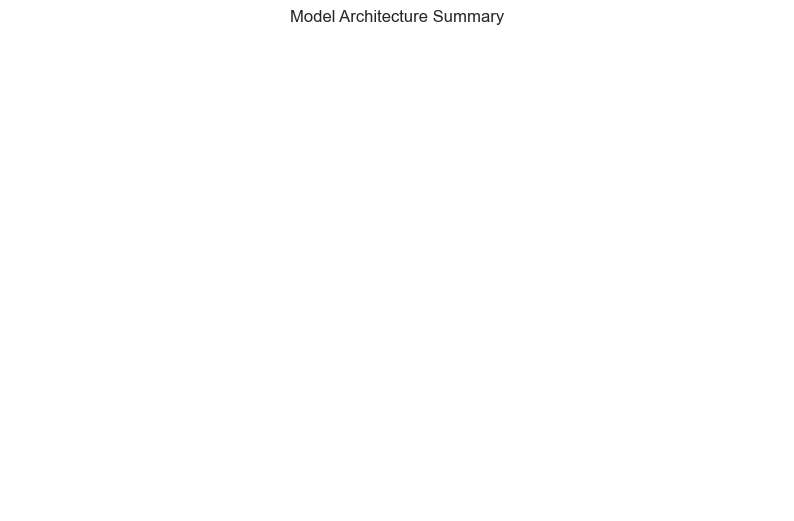

Key Model Details:
• Input shape: (76,)
• Output shape: (2,)
• Total params: 215,874
• Trainable layers: 18


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Load the model
model = load_model("model_results_large_with_shap/best_model.h5")

# Generate architecture diagram
plt.figure(figsize=(10, 6))
plot_model(model,
           to_file='model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           dpi=96,
           rankdir='TB')  # TB = top to bottom layout
plt.title('Model Architecture Summary', pad=20)
plt.axis('off')
plt.show()

# Print concise summary
print("\033[1m" + "Key Model Details:" + "\033[0m")
print(f"• Input shape: {model.input_shape[1:]}")
print(f"• Output shape: {model.output_shape[1:]}")
print(f"• Total params: {model.count_params():,}")
print(f"• Trainable layers: {len(model.trainable_weights)}")

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import Image, display  # For Jupyter notebooks
import numpy as np

# Load your model
model = load_model("model_results_large_with_shap/best_model.h5")

# 1. Generate and display visual architecture
print("\n\033[1m=== MODEL ARCHITECTURE ===\033[0m")
plot_model(model,
           to_file='model_arch.png',
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True,
           dpi=70,
           rankdir='TB')  # Top-to-bottom layout

try:
    display(Image('model_arch.png', width=600))  # For Jupyter
except:
    img = plt.imread('model_arch.png')
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 2. Print enhanced text summary
print("\n\033[1m=== MODEL SUMMARY ===\033[0m")
model.summary(line_length=80, positions=[0.3, 0.6, 0.8, 1.0])

# 3. Key metrics extraction
print("\n\033[1m=== KEY STATS ===\033[0m")
print(f"• Input Shape: {model.input_shape[1:]}")
print(f"• Output Shape: {model.output_shape[1:]}")
print(f"• Total Parameters: {model.count_params():,}")
print(f"• Trainable Parameters: {sum([np.prod(w.shape) for w in model.trainable_weights]):,}")
print(f"• Non-Trainable Parameters: {sum([np.prod(w.shape) for w in model.non_trainable_weights]):,}")

# 4. Layer-type breakdown
print("\n\033[1m=== LAYER TYPES ===\033[0m")
layer_types = set([layer.__class__.__name__ for layer in model.layers])
for i, lt in enumerate(layer_types, 1):
    print(f"{i}. {lt}")


=== MODEL ARCHITECTURE ===
You must install pydot (`pip install pydot`) for `plot_model` to work.


FileNotFoundError: No such file or directory: 'model_arch.png'

FileNotFoundError: No such file or directory: 'model_arch.png'

<IPython.core.display.Image object>


=== MODEL SUMMARY ===


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape               ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)           │ (None, 512)                │            39,424 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ batch_normalization         │ (None, 512)                │             2,048 │
│ (BatchNormalization)        │                            │                   │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dropout_200 (Dropout)       │ (None, 512)                │                 0 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dense_301 (Dense)           │ (None, 256)                │           131,328 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ batch_normalization_1       │ (None, 256)                │             1,024 │
│ (BatchNormalization)        │                            │                   │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dropout_201 (Dropout)       │ (None, 256)                │                 0 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dense_302 (Dense)           │ (None, 128)                │            32,896 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ batch_normalization_2       │ (None, 128)                │               512 │
│ (BatchNormalization)        │                            │                   │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dropout_202 (Dropout)       │ (None, 128)                │                 0 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dense_303 (Dense)           │ (None, 64)                 │             8,256 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ batch_normalization_3       │ (None, 64)                 │               256 │
│ (BatchNormalization)        │                            │                   │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dropout_203 (Dropout)       │ (None, 64)                 │                 0 │
├─────────────────────────────┼────────────────────────────┼───────────────────┤
│ dense_304 (Dense)           │ (None, 2)                  │               130 │
└─────────────────────────────┴────────────────────────────┴───────────────────┘

 Total params: 215,876 (843.27 KB)

 Trainable params: 213,954 (835.76 KB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)


=== KEY STATS ===
• Input Shape: (76,)
• Output Shape: (2,)
• Total Parameters: 215,874
• Trainable Parameters: 213,954
• Non-Trainable Parameters: 1,920

=== LAYER TYPES ===
1. Dense
2. Dropout
3. BatchNormalization


In [14]:
import shap
import joblib
import numpy as np
from tensorflow.keras.models import load_model

# Load your pre-existing files
model = load_model("model_results_large_with_shap/best_model.h5")
background_data = joblib.load("model_results_large_with_shap/background_data.joblib")
scaler = joblib.load("model_results_large_with_shap/scaler.joblib")

# Scale the background data
background_data_scaled = scaler.transform(background_data)

# Create and compute SHAP values (but don't try to save the explainer)
explainer = shap.DeepExplainer(
    model,
    background_data_scaled[:100]  # Using first 100 samples as background
)

# Calculate SHAP values for the same background samples
shap_values = explainer.shap_values(background_data_scaled[:100])

# Save just the SHAP values and background data
joblib.dump(shap_values, "model_results_large_with_shap/shap_values.joblib")

# For your app, you'll need to recreate the explainer each time
print("SHAP values saved successfully! Note: Explainers must be recreated at runtime")

C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_100
Received: inputs=['Tensor(shape=(100, 76))']
  warnings.warn(msg)
C:\Users\adity\X-AI for music classification\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_100
Received: inputs=['Tensor(shape=(200, 76))']
  warnings.warn(msg)


SHAP values saved successfully! Note: Explainers must be recreated at runtime


In [7]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shap

# Configuration
PROCESSED_DIR = "c:/Users/adity/Downloads/X_AI_for_fake_real_audio_detection/processed_audio/"
RESULTS_DIR = "model_results_full_verified"
SR = 22050
FEATURE_COUNT = 76
N_SPLITS = 10
N_REPEATS = 5
BACKGROUND_SAMPLES = 100
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_processed_dataset():
    """Load preprocessed features and labels"""
    try:
        X = np.load(os.path.join(PROCESSED_DIR, "features.npy"))
        y = np.load(os.path.join(PROCESSED_DIR, "labels.npy"))

        print(f"\nDataset loaded successfully:")
        print(f"- Total samples: {len(X)}")
        print(f"- Features per sample: {X.shape[1]}")
        print(f"- Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

        return X, y
    except Exception as e:
        print(f"\nError loading dataset: {str(e)}")
        return np.array([]), np.array([])

def create_model():
    """Create optimized neural network model"""
    model = Sequential([
        Dense(128, activation='relu', input_shape=(FEATURE_COUNT,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),

        Dense(2, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

def save_training_plots(history, repeat, fold):
    """Save training history plots"""
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Repeat {repeat} Fold {fold} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Repeat {repeat} Fold {fold} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/repeat_{repeat}_fold_{fold}_training.png")
    plt.close()

def save_confusion_matrix(y_true, y_pred, repeat, fold):
    """Save confusion matrix visualization"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Fake', 'Real'],
               yticklabels=['Fake', 'Real'])
    plt.title(f'Repeat {repeat} Fold {fold}\nAccuracy: {np.sum(np.diag(cm))/np.sum(cm):.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{RESULTS_DIR}/repeat_{repeat}_fold_{fold}_cm.png")
    plt.close()

def save_fold_results(repeat, fold, y_true, y_pred, y_probs, test_indices):
    """Save detailed fold results"""
    fold_dir = f"{RESULTS_DIR}/repeat_{repeat}/fold_{fold}"
    os.makedirs(fold_dir, exist_ok=True)

    # Save indices and raw predictions
    np.save(f"{fold_dir}/test_indices.npy", test_indices)
    np.save(f"{fold_dir}/y_true.npy", y_true)
    np.save(f"{fold_dir}/y_pred.npy", y_pred)
    np.save(f"{fold_dir}/y_probs.npy", y_probs)

    # Save classification report
    report = classification_report(y_true, y_pred, target_names=['Fake', 'Real'], output_dict=True)
    joblib.dump(report, f"{fold_dir}/classification_report.joblib")

    # Save ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f"{fold_dir}/roc_curve.png")
    plt.close()

def generate_shap_explanations(model, X_train, X_test, feature_names):
    """Generate SHAP explanations for model predictions"""
    try:
        print("\nGenerating SHAP explanations...")

        # Create explainer with background data
        background = shap.sample(X_train, BACKGROUND_SAMPLES)
        explainer = shap.DeepExplainer(model, background)

        # Calculate SHAP values for test samples
        test_samples = X_test[:50]  # Use first 50 test samples for efficiency
        shap_values = explainer.shap_values(test_samples)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], test_samples, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_DIR}/shap_summary.png')
        plt.close()

        # Save SHAP values
        joblib.dump(shap_values, f'{RESULTS_DIR}/shap_values.joblib')
        print("SHAP analysis completed and saved.")

    except Exception as e:
        print(f"Error in SHAP explanation: {str(e)}")

def get_feature_names():
    """Return descriptive feature names"""
    return [
        *[f"MFCC_mean_{i}" for i in range(20)],
        *[f"MFCC_std_{i}" for i in range(20)],
        "Chroma_mean", "Chroma_std",
        "SpectralCentroid_mean", "SpectralCentroid_std",
        "SpectralBandwidth_mean", "SpectralBandwidth_std",
        "SpectralRolloff_mean", "SpectralRolloff_std",
        "ZCR_mean", "ZCR_std",
        "RMS_mean", "RMS_std",
        *[f"SpectralContrast_mean_{i}" for i in range(6)],
        *[f"SpectralContrast_std_{i}" for i in range(6)],
        *[f"Tonnetz_mean_{i}" for i in range(6)],
        *[f"Tonnetz_std_{i}" for i in range(6)]
    ]

def main():
    # Load and verify dataset
    X, y = load_processed_dataset()
    if len(X) == 0:
        print("No valid samples found. Exiting.")
        return

    # Initialize results tracking
    all_accuracies = []
    best_accuracy = 0
    best_model_path = f"{RESULTS_DIR}/best_model.h5"
    feature_names = get_feature_names()

    print(f"\nStarting {N_REPEATS}×{N_SPLITS}-fold cross-validation...")

    for repeat in range(N_REPEATS):
        print(f"\n\n=== REPEAT {repeat+1}/{N_REPEATS} ===")
        kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=repeat)

        for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
            print(f"\nFold {fold+1}/{N_SPLITS}")
            print(f"Train samples: {len(train_idx)} (Fake: {sum(y[train_idx]==0)}, Real: {sum(y[train_idx]==1)})")
            print(f"Test samples:  {len(test_idx)} (Fake: {sum(y[test_idx]==0)}, Real: {sum(y[test_idx]==1)})")

            # Scale data inside the fold
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X[train_idx])
            X_test = scaler.transform(X[test_idx])
            y_train, y_test = y[train_idx], y[test_idx]

            # Train model
            model = create_model()
            history = model.fit(
                X_train, y_train,
                epochs=100,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[
                    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
                    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
                ],
                verbose=1
            )

            # Evaluate
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            all_accuracies.append(accuracy)
            y_pred = model.predict(X_test).argmax(axis=1)
            y_probs = model.predict(X_test)

            # Save results
            save_training_plots(history, repeat+1, fold+1)
            save_confusion_matrix(y_test, y_pred, repeat+1, fold+1)
            save_fold_results(repeat+1, fold+1, y_test, y_pred, y_probs, test_idx)

            # Track best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                save_model(model, best_model_path)
                joblib.dump(scaler, f"{RESULTS_DIR}/best_scaler.joblib")
                print(f"New best model saved (Accuracy: {best_accuracy:.4f})")

            print(f"Fold accuracy: {accuracy:.4f}")

    # Final evaluation
    print("\n\n=== FINAL RESULTS ===")
    print(f"Mean accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})")
    print(f"Best accuracy: {best_accuracy:.4f}")
    print(f"Worst accuracy: {np.min(all_accuracies):.4f}")

    # Save comprehensive report
    with open(f"{RESULTS_DIR}/final_report.txt", "w") as f:
        f.write(f"{N_REPEATS}×{N_SPLITS}-Fold Cross Validation Results\n")
        f.write(f"Mean Accuracy: {np.mean(all_accuracies):.4f} (±{np.std(all_accuracies):.4f})\n")
        f.write(f"Best Accuracy: {best_accuracy:.4f}\n")
        f.write(f"Worst Accuracy: {np.min(all_accuracies):.4f}\n")

    # Generate SHAP explanations for best model
    if os.path.exists(best_model_path):
        print("\nLoading best model for SHAP explanations...")
        best_model = load_model(best_model_path)
        best_scaler = joblib.load(f"{RESULTS_DIR}/best_scaler.joblib")

        # Get background data from all training folds
        background_indices = []
        for repeat in range(N_REPEATS):
            for fold in range(N_SPLITS):
                try:
                    test_indices = np.load(f"{RESULTS_DIR}/repeat_{repeat+1}/fold_{fold+1}/test_indices.npy")
                    background_indices.extend([i for i in range(len(X)) if i not in test_indices])
                except:
                    continue

        background_data = best_scaler.transform(X[np.random.choice(background_indices,
                                                min(1000, len(background_indices)), replace=False)])
        test_data = best_scaler.transform(X[:50])  # Explain first 50 samples

        generate_shap_explanations(best_model, background_data, test_data, feature_names)

    print(f"\nAll results saved in '{RESULTS_DIR}' directory")

if __name__ == "__main__":
    main()

ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

In [5]:
import  tqdm

In [3]:
import os